In [1]:
# Let's get started importing everything we need!

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
original_dim = 784       # mnist images are of size 28*28=784
batch_size = 100         #size of batches
latent_dim = 2           #latent space size i.e dimension of mean and standard_deviation
intermediate_dim = 256   #intermediate dimension size
epochs = 50              #no of epochs
epsilon_std = 1.0        #parameter which helps in sampling from latent space z

In [3]:
# Encoder Part
x = Input(shape=(original_dim,))                     # placeholder for input image
h = Dense(intermediate_dim, activation='relu')(x)    #First layer of encoder is a fully connected layer
z_mean = Dense(latent_dim)(h)                        # fully connected layer which calculates value for latent dimension mean z_mean
z_log_var = Dense(latent_dim)(h)                     # fully connected layer which calculates value for latent dimension std_deviation z_log_var

In [4]:
# Sampling function which produces a sample using the mean and std_deviation for the decoder to decode
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean = 0, stddev = epsilon_std)
    return z_mean + K.exp(z_log_var/2) * epsilon

In [5]:
#  Lambda wraps arbitrary expression as a Layer object. This serves to be an input to the decoder.
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var])  # https://keras.io/layers/core/#lambda

In [6]:
# Decoder Part
decoder_h = Dense(intermediate_dim, activation='relu')      #instantiating these layers as these will be needed further for predicting output from latent variables.
decoder_mean = Dense(original_dim, activation='sigmoid')    #instantiating these layers as these will be needed further for predicting output from latent variables.
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [21]:
# Creating a VAE model
vae = Model(x, x_decoded_mean)

#Creating an encoder model
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)

# Creating a decoder model
generator = Model(decoder_input, _x_decoded_mean)

In [22]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)                # reconstruction loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)    #Kl divergence loss, this meaures the difference between the current enocded value(latent space) with the actual value. This should be as low as possible.
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer = 'rmsprop',loss = vae_loss)
vae.summary()       #structure of the whole variational autoencoder

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [23]:
# load training as well as test data
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# print("Training Data Shape X:", x_train.shape," y: ", y_train.shape)
# print("Test Data Shape X:", x_test.shape," y: ", y_test.shape)

# Normalizing the values of training and test set
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

# converting data into specific shape so that it could be fed into the model i.e flattening each example from (28,28) to (784) size 
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))

x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

In [24]:
# training for 50 epochs
vae.fit(x_train,x_train,
        shuffle=True,
        epochs=15,
        batch_size=batch_size,
        validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15


  100/60000 [..............................] - ETA: 9:34 - loss: 202.6943

  500/60000 [..............................] - ETA: 2:00 - loss: 2398647.3504

  900/60000 [..............................] - ETA: 1:11 - loss: 1332690.2846

 1400/60000 [..............................] - ETA: 48s - loss: 856800.9649  

 1900/60000 [..............................] - ETA: 37s - loss: 631385.4164



 2200/60000 [>.............................] - ETA: 33s - loss: 545313.4087

 2700/60000 [>.............................] - ETA: 28s - loss: 444368.0519

 3200/60000 [>.............................] - ETA: 25s - loss: 374966.3744

 3800/60000 [>.............................] - ETA: 22s - loss: 315795.8939



 4400/60000 [=>............................] - ETA: 19s - loss: 272763.0472

 4800/60000 [=>............................] - ETA: 18s - loss: 250050.0605



 5300/60000 [=>............................] - ETA: 17s - loss: 226482.7748



 5700/60000 [=>............................] - ETA: 16s - loss: 210604.1322

 6200/60000 [==>...........................] - ETA: 15s - loss: 193640.1258

 6600/60000 [==>...........................] - ETA: 15s - loss: 181916.2333

 7200/60000 [==>...........................] - ETA: 14s - loss: 166775.4086

 7600/60000 [==>...........................] - ETA: 13s - loss: 158008.9583



 8100/60000 [===>..........................] - ETA: 13s - loss: 148268.4254

 8400/60000 [===>..........................] - ETA: 13s - loss: 142981.1211



 8800/60000 [===>..........................] - ETA: 12s - loss: 136491.3887

 9200/60000 [===>..........................] - ETA: 12s - loss: 130566.0967

 9900/60000 [===>..........................] - ETA: 11s - loss: 121350.2145

10600/60000 [====>.........................] - ETA: 10s - loss: 113350.3293

11300/60000 [====>.........................] - ETA: 10s - loss: 106342.6187

12000/60000 [=====>........................] - ETA: 9s - loss: 100151.7014 

12600/60000 [=====>........................] - ETA: 9s - loss: 95394.3290 

13300/60000 [=====>........................] - ETA: 8s - loss: 90384.6717

14000/60000 [======>.......................] - ETA: 8s - loss: 85875.7134

14700/60000 [======>.......................] - ETA: 8s - loss: 81796.8751

15400/60000 [======>.......................] - ETA: 7s - loss: 78089.0134

16100/60000 [=======>......................] - ETA: 7s - loss: 74704.1528

16800/60000 [=======>......................] - ETA: 7s - loss: 71600.3423

17400/60000 [=======>......................] - ETA: 7s - loss: 69138.3148

18100/60000 [========>.....................] - ETA: 6s - loss: 66473.1613

18800/60000 [========>.....................] - ETA: 6s - loss: 64005.8515

19500/60000 [========>.....................] - ETA: 6s - loss: 61715.9929

20200/60000 [=========>....................] - ETA: 6s - loss: 59585.1209

20900/60000 [=========>....................] - ETA: 5s - loss: 57596.6076

21600/60000 [=========>....................] - ETA: 5s - loss: 55737.6263

22300/60000 [==========>...................] - ETA: 5s - loss: 53994.6354

23000/60000 [==========>...................] - ETA: 5s - loss: 52357.6229

23700/60000 [==========>...................] - ETA: 5s - loss: 50817.8589

24400/60000 [===========>..................] - ETA: 4s - loss: 49366.0626

25100/60000 [===========>..................] - ETA: 4s - loss: 47995.7257

25800/60000 [===========>..................] - ETA: 4s - loss: 46699.6110

26500/60000 [============>.................] - ETA: 4s - loss: 45471.8791

27100/60000 [============>.................] - ETA: 4s - loss: 44470.2449

27800/60000 [============>.................] - ETA: 4s - loss: 43355.8619

28500/60000 [=============>................] - ETA: 4s - loss: 42296.4132

29200/60000 [=============>................] - ETA: 4s - loss: 41287.7492

29900/60000 [=============>................] - ETA: 3s - loss: 40325.9086

30600/60000 [==============>...............] - ETA: 3s - loss: 39408.8515

31100/60000 [==============>...............] - ETA: 3s - loss: 38778.7195

31800/60000 [==============>...............] - ETA: 3s - loss: 37929.8371

32500/60000 [===============>..............] - ETA: 3s - loss: 37118.0649

33200/60000 [===============>..............] - ETA: 3s - loss: 36339.9970

33900/60000 [===============>..............] - ETA: 3s - loss: 35594.3241

34600/60000 [================>.............] - ETA: 3s - loss: 34878.5844

35300/60000 [================>.............] - ETA: 3s - loss: 34191.1146

36000/60000 [=================>............] - ETA: 2s - loss: 33530.5376

36700/60000 [=================>............] - ETA: 2s - loss: 32895.1069

37400/60000 [=================>............] - ETA: 2s - loss: 32283.6568

38100/60000 [==================>...........] - ETA: 2s - loss: 31694.7058

38800/60000 [==================>...........] - ETA: 2s - loss: 31126.5694

39500/60000 [==================>...........] - ETA: 2s - loss: 30578.9413

40200/60000 [===================>..........] - ETA: 2s - loss: 30050.2343

40900/60000 [===================>..........] - ETA: 2s - loss: 29539.7189

41600/60000 [===================>..........] - ETA: 2s - loss: 29046.5633

42300/60000 [====================>.........] - ETA: 2s - loss: 28569.6204

43000/60000 [====================>.........] - ETA: 1s - loss: 28108.0058

43700/60000 [====================>.........] - ETA: 1s - loss: 27661.3810

44200/60000 [=====================>........] - ETA: 1s - loss: 27350.7388

44800/60000 [=====================>........] - ETA: 1s - loss: 26987.3101

45500/60000 [=====================>........] - ETA: 1s - loss: 26575.4967

46200/60000 [======================>.......] - ETA: 1s - loss: 26176.1200

46900/60000 [======================>.......] - ETA: 1s - loss: 25788.9102

47600/60000 [======================>.......] - ETA: 1s - loss: 25412.9704

48300/60000 [=======================>......] - ETA: 1s - loss: 25047.6098

49000/60000 [=======================>......] - ETA: 1s - loss: 24693.0024

49700/60000 [=======================>......] - ETA: 1s - loss: 24348.3263

50400/60000 [========================>.....] - ETA: 1s - loss: 24013.3805

51100/60000 [========================>.....] - ETA: 0s - loss: 23687.1859

51800/60000 [========================>.....] - ETA: 0s - loss: 23370.1659

52400/60000 [=========================>....] - ETA: 0s - loss: 23104.9334

53100/60000 [=========================>....] - ETA: 0s - loss: 22803.3170

53800/60000 [=========================>....] - ETA: 0s - loss: 22509.2898

54500/60000 [==========================>...] - ETA: 0s - loss: 22222.9423

55200/60000 [==========================>...] - ETA: 0s - loss: 21944.1110

55900/60000 [==========================>...] - ETA: 0s - loss: 21671.8435

56600/60000 [===========================>..] - ETA: 0s - loss: 21406.4391

57200/60000 [===========================>..] - ETA: 0s - loss: 21184.1914

57800/60000 [===========================>..] - ETA: 0s - loss: 20966.6356

58500/60000 [============================>.] - ETA: 0s - loss: 20718.2953

59200/60000 [============================>.] - ETA: 0s - loss: 20476.0048

59900/60000 [============================>.] - ETA: 0s - loss: 20239.2828

60000/60000 [==============================] - 7s 110us/step - loss: 20205.9475 - val_loss: 201.6907


Epoch 2/15
  100/60000 [..............................] - ETA: 9s - loss: 204.6808

  700/60000 [..............................] - ETA: 6s - loss: 246.5687

 1400/60000 [..............................] - ETA: 5s - loss: 230.3934

 2000/60000 [>.............................] - ETA: 5s - loss: 222.1749

 2700/60000 [>.............................] - ETA: 5s - loss: 219.9361

 3400/60000 [>.............................] - ETA: 4s - loss: 220.2644

 4100/60000 [=>............................] - ETA: 4s - loss: 219.7368

 4800/60000 [=>............................] - ETA: 4s - loss: 220.3770

 5300/60000 [=>............................] - ETA: 4s - loss: 220.5375

 5900/60000 [=>............................] - ETA: 4s - loss: 221.0171

 6600/60000 [==>...........................] - ETA: 4s - loss: 219.4807

 7300/60000 [==>...........................] - ETA: 4s - loss: 219.3101

 8000/60000 [===>..........................] - ETA: 4s - loss: 221.4606

 8700/60000 [===>..........................] - ETA: 4s - loss: 220.0064

 9400/60000 [===>..........................] - ETA: 4s - loss: 220.3328

10100/60000 [====>.........................] - ETA: 4s - loss: 219.8630

10800/60000 [====>.........................] - ETA: 4s - loss: 222.1782

11500/60000 [====>.........................] - ETA: 3s - loss: 222.7120

12100/60000 [=====>........................] - ETA: 3s - loss: 221.8007

12800/60000 [=====>........................] - ETA: 3s - loss: 221.2188

13500/60000 [=====>........................] - ETA: 3s - loss: 222.0085

14200/60000 [======>.......................] - ETA: 3s - loss: 221.4879

14900/60000 [======>.......................] - ETA: 3s - loss: 222.1398

15600/60000 [======>.......................] - ETA: 3s - loss: 221.3686

16300/60000 [=======>......................] - ETA: 3s - loss: 221.3220

17000/60000 [=======>......................] - ETA: 3s - loss: 221.5226

17700/60000 [=======>......................] - ETA: 3s - loss: 221.2658

18300/60000 [========>.....................] - ETA: 3s - loss: 221.2256

19000/60000 [========>.....................] - ETA: 3s - loss: 221.2056

19700/60000 [========>.....................] - ETA: 3s - loss: 221.1019

20400/60000 [=========>....................] - ETA: 3s - loss: 221.3631

21100/60000 [=========>....................] - ETA: 3s - loss: 221.4793

21800/60000 [=========>....................] - ETA: 3s - loss: 221.1054

22500/60000 [==========>...................] - ETA: 3s - loss: 221.1506

23100/60000 [==========>...................] - ETA: 2s - loss: 221.0019

23800/60000 [==========>...................] - ETA: 2s - loss: 222.0216

24500/60000 [===========>..................] - ETA: 2s - loss: 222.3049

25200/60000 [===========>..................] - ETA: 2s - loss: 221.5062

25900/60000 [===========>..................] - ETA: 2s - loss: 221.2634

26600/60000 [============>.................] - ETA: 2s - loss: 222.0360

27300/60000 [============>.................] - ETA: 2s - loss: 222.1188

28000/60000 [=============>................] - ETA: 2s - loss: 221.9867

28700/60000 [=============>................] - ETA: 2s - loss: 221.8347

29400/60000 [=============>................] - ETA: 2s - loss: 222.0840

30100/60000 [==============>...............] - ETA: 2s - loss: 222.6351

30800/60000 [==============>...............] - ETA: 2s - loss: 222.5578

31500/60000 [==============>...............] - ETA: 2s - loss: 222.0852

32000/60000 [===============>..............] - ETA: 2s - loss: 222.0578

32700/60000 [===============>..............] - ETA: 2s - loss: 222.5554

33400/60000 [===============>..............] - ETA: 2s - loss: 222.4861

34100/60000 [================>.............] - ETA: 2s - loss: 222.3167

34800/60000 [================>.............] - ETA: 2s - loss: 222.4937

35500/60000 [================>.............] - ETA: 1s - loss: 222.4941

36200/60000 [=================>............] - ETA: 1s - loss: 222.3938

36900/60000 [=================>............] - ETA: 1s - loss: 222.5564

37500/60000 [=================>............] - ETA: 1s - loss: 222.4876

38200/60000 [==================>...........] - ETA: 1s - loss: 222.4652

38900/60000 [==================>...........] - ETA: 1s - loss: 222.1805

39600/60000 [==================>...........] - ETA: 1s - loss: 222.1907

40300/60000 [===================>..........] - ETA: 1s - loss: 222.3730

41000/60000 [===================>..........] - ETA: 1s - loss: 222.2790

41700/60000 [===================>..........] - ETA: 1s - loss: 222.6452

42400/60000 [====================>.........] - ETA: 1s - loss: 222.9129

43000/60000 [====================>.........] - ETA: 1s - loss: 222.7982

43600/60000 [====================>.........] - ETA: 1s - loss: 222.9531

44300/60000 [=====================>........] - ETA: 1s - loss: 223.0226

44800/60000 [=====================>........] - ETA: 1s - loss: 222.8301

45500/60000 [=====================>........] - ETA: 1s - loss: 222.6297

46200/60000 [======================>.......] - ETA: 1s - loss: 222.9647

46900/60000 [======================>.......] - ETA: 1s - loss: 222.7976

47600/60000 [======================>.......] - ETA: 0s - loss: 222.4601

48200/60000 [=======================>......] - ETA: 0s - loss: 222.5938

48900/60000 [=======================>......] - ETA: 0s - loss: 222.5355

49600/60000 [=======================>......] - ETA: 0s - loss: 222.8649

50300/60000 [========================>.....] - ETA: 0s - loss: 222.6770

50900/60000 [========================>.....] - ETA: 0s - loss: 223.0007

51600/60000 [========================>.....] - ETA: 0s - loss: 222.6956

52300/60000 [=========================>....] - ETA: 0s - loss: 222.5851

53000/60000 [=========================>....] - ETA: 0s - loss: 222.6839

53700/60000 [=========================>....] - ETA: 0s - loss: 222.7380

54400/60000 [==========================>...] - ETA: 0s - loss: 222.7241

55100/60000 [==========================>...] - ETA: 0s - loss: 222.7233

55800/60000 [==========================>...] - ETA: 0s - loss: 223.1664

56500/60000 [===========================>..] - ETA: 0s - loss: 223.2249

57200/60000 [===========================>..] - ETA: 0s - loss: 223.1298

57700/60000 [===========================>..] - ETA: 0s - loss: 223.3566

58400/60000 [============================>.] - ETA: 0s - loss: 223.2879

59100/60000 [============================>.] - ETA: 0s - loss: 223.3743

59800/60000 [============================>.] - ETA: 0s - loss: 223.4149

60000/60000 [==============================] - 5s 85us/step - loss: 223.4971 - val_loss: 201.0930


Epoch 3/15
  100/60000 [..............................] - ETA: 9s - loss: 205.3497

  700/60000 [..............................] - ETA: 5s - loss: 229.2670

 1400/60000 [..............................] - ETA: 5s - loss: 225.2503

 2100/60000 [>.............................] - ETA: 4s - loss: 221.9133

 2800/60000 [>.............................] - ETA: 4s - loss: 223.9427

 3500/60000 [>.............................] - ETA: 4s - loss: 222.2801

 4200/60000 [=>............................] - ETA: 4s - loss: 224.3094

 4900/60000 [=>............................] - ETA: 4s - loss: 223.1630

 5600/60000 [=>............................] - ETA: 4s - loss: 221.0628

 6300/60000 [==>...........................] - ETA: 4s - loss: 223.0458

 7000/60000 [==>...........................] - ETA: 4s - loss: 222.8461

 7500/60000 [==>...........................] - ETA: 4s - loss: 223.6241

 8200/60000 [===>..........................] - ETA: 4s - loss: 223.5920

 8900/60000 [===>..........................] - ETA: 4s - loss: 222.7305

 9600/60000 [===>..........................] - ETA: 4s - loss: 223.5282

10300/60000 [====>.........................] - ETA: 4s - loss: 225.3347

11000/60000 [====>.........................] - ETA: 3s - loss: 224.2399

11700/60000 [====>.........................] - ETA: 3s - loss: 222.7864

12400/60000 [=====>........................] - ETA: 3s - loss: 223.8354

13100/60000 [=====>........................] - ETA: 3s - loss: 223.6915

13800/60000 [=====>........................] - ETA: 3s - loss: 223.5524

14500/60000 [======>.......................] - ETA: 3s - loss: 223.6805

15200/60000 [======>.......................] - ETA: 3s - loss: 223.8809

15900/60000 [======>.......................] - ETA: 3s - loss: 223.7525

16600/60000 [=======>......................] - ETA: 3s - loss: 223.9075

17300/60000 [=======>......................] - ETA: 3s - loss: 223.2809

17800/60000 [=======>......................] - ETA: 3s - loss: 223.9182

18400/60000 [========>.....................] - ETA: 3s - loss: 223.6768

19100/60000 [========>.....................] - ETA: 3s - loss: 223.1340

19800/60000 [========>.....................] - ETA: 3s - loss: 223.1355

20300/60000 [=========>....................] - ETA: 3s - loss: 224.1581

21000/60000 [=========>....................] - ETA: 3s - loss: 224.2673

21700/60000 [=========>....................] - ETA: 3s - loss: 223.5034

22300/60000 [==========>...................] - ETA: 3s - loss: 223.9250

23000/60000 [==========>...................] - ETA: 2s - loss: 223.9436

23700/60000 [==========>...................] - ETA: 2s - loss: 224.0255

24400/60000 [===========>..................] - ETA: 2s - loss: 224.4993

25100/60000 [===========>..................] - ETA: 2s - loss: 224.2793

25800/60000 [===========>..................] - ETA: 2s - loss: 224.2882

26500/60000 [============>.................] - ETA: 2s - loss: 224.1821

27200/60000 [============>.................] - ETA: 2s - loss: 224.6270

27900/60000 [============>.................] - ETA: 2s - loss: 224.1391

28600/60000 [=============>................] - ETA: 2s - loss: 224.3991

29300/60000 [=============>................] - ETA: 2s - loss: 224.3586

30000/60000 [==============>...............] - ETA: 2s - loss: 224.5503

30700/60000 [==============>...............] - ETA: 2s - loss: 225.0089

31400/60000 [==============>...............] - ETA: 2s - loss: 224.8045

32100/60000 [===============>..............] - ETA: 2s - loss: 224.6159

32800/60000 [===============>..............] - ETA: 2s - loss: 224.8746

33300/60000 [===============>..............] - ETA: 2s - loss: 224.8678

34000/60000 [================>.............] - ETA: 2s - loss: 225.0549

34600/60000 [================>.............] - ETA: 2s - loss: 224.8532

35300/60000 [================>.............] - ETA: 1s - loss: 224.7614

36000/60000 [=================>............] - ETA: 1s - loss: 224.8596

36700/60000 [=================>............] - ETA: 1s - loss: 224.9640

37400/60000 [=================>............] - ETA: 1s - loss: 225.0000

38100/60000 [==================>...........] - ETA: 1s - loss: 224.8789

38800/60000 [==================>...........] - ETA: 1s - loss: 225.0516

39500/60000 [==================>...........] - ETA: 1s - loss: 224.8085

40200/60000 [===================>..........] - ETA: 1s - loss: 225.0272

40900/60000 [===================>..........] - ETA: 1s - loss: 225.2793

41600/60000 [===================>..........] - ETA: 1s - loss: 225.1539

42300/60000 [====================>.........] - ETA: 1s - loss: 225.4932

43000/60000 [====================>.........] - ETA: 1s - loss: 225.4025

43700/60000 [====================>.........] - ETA: 1s - loss: 225.2723

44400/60000 [=====================>........] - ETA: 1s - loss: 225.3063

45100/60000 [=====================>........] - ETA: 1s - loss: 225.4023

45800/60000 [=====================>........] - ETA: 1s - loss: 225.7218

46500/60000 [======================>.......] - ETA: 1s - loss: 225.5758

47100/60000 [======================>.......] - ETA: 1s - loss: 225.6612

47800/60000 [======================>.......] - ETA: 0s - loss: 226.1040

48500/60000 [=======================>......] - ETA: 0s - loss: 225.9492

49100/60000 [=======================>......] - ETA: 0s - loss: 225.8124

49800/60000 [=======================>......] - ETA: 0s - loss: 226.0918

50500/60000 [========================>.....] - ETA: 0s - loss: 225.8178

51200/60000 [========================>.....] - ETA: 0s - loss: 225.7284

51900/60000 [========================>.....] - ETA: 0s - loss: 225.6107

52600/60000 [=========================>....] - ETA: 0s - loss: 225.6653

53300/60000 [=========================>....] - ETA: 0s - loss: 225.5783

54000/60000 [==========================>...] - ETA: 0s - loss: 225.4279

54700/60000 [==========================>...] - ETA: 0s - loss: 225.5003

55400/60000 [==========================>...] - ETA: 0s - loss: 225.7157

56100/60000 [===========================>..] - ETA: 0s - loss: 225.5841

56800/60000 [===========================>..] - ETA: 0s - loss: 225.6480

57500/60000 [===========================>..] - ETA: 0s - loss: 225.8969

58200/60000 [============================>.] - ETA: 0s - loss: 225.8417

58900/60000 [============================>.] - ETA: 0s - loss: 225.8394

59500/60000 [============================>.] - ETA: 0s - loss: 225.9229

60000/60000 [==============================] - 5s 84us/step - loss: 225.7905 - val_loss: 288.4531


Epoch 4/15
  100/60000 [..............................] - ETA: 8s - loss: 275.9306

  700/60000 [..............................] - ETA: 5s - loss: 242.2932

 1400/60000 [..............................] - ETA: 5s - loss: 223.0837

 2100/60000 [>.............................] - ETA: 4s - loss: 227.9105

 2600/60000 [>.............................] - ETA: 5s - loss: 226.0865

 3200/60000 [>.............................] - ETA: 5s - loss: 225.0644

 3900/60000 [>.............................] - ETA: 4s - loss: 224.9375

 4600/60000 [=>............................] - ETA: 4s - loss: 227.3369

 5300/60000 [=>............................] - ETA: 4s - loss: 229.1632

 6000/60000 [==>...........................] - ETA: 4s - loss: 227.4509

 6700/60000 [==>...........................] - ETA: 4s - loss: 228.8004

 7400/60000 [==>...........................] - ETA: 4s - loss: 229.4859

 8100/60000 [===>..........................] - ETA: 4s - loss: 228.8809

 8800/60000 [===>..........................] - ETA: 4s - loss: 228.6584

 9300/60000 [===>..........................] - ETA: 4s - loss: 227.9495

10000/60000 [====>.........................] - ETA: 4s - loss: 227.2471

10600/60000 [====>.........................] - ETA: 4s - loss: 227.2329

11300/60000 [====>.........................] - ETA: 4s - loss: 226.9831

12000/60000 [=====>........................] - ETA: 4s - loss: 226.7491

12700/60000 [=====>........................] - ETA: 3s - loss: 227.0904

13400/60000 [=====>........................] - ETA: 3s - loss: 228.0525

14100/60000 [======>.......................] - ETA: 3s - loss: 228.4342

14800/60000 [======>.......................] - ETA: 3s - loss: 227.7732

15500/60000 [======>.......................] - ETA: 3s - loss: 228.2745

16200/60000 [=======>......................] - ETA: 3s - loss: 227.6488

16900/60000 [=======>......................] - ETA: 3s - loss: 228.3308

17600/60000 [=======>......................] - ETA: 3s - loss: 227.9485

18300/60000 [========>.....................] - ETA: 3s - loss: 228.8803

19000/60000 [========>.....................] - ETA: 3s - loss: 228.8432

19700/60000 [========>.....................] - ETA: 3s - loss: 228.6173

20400/60000 [=========>....................] - ETA: 3s - loss: 228.8850

21000/60000 [=========>....................] - ETA: 3s - loss: 228.5986

21700/60000 [=========>....................] - ETA: 3s - loss: 228.6390

22200/60000 [==========>...................] - ETA: 3s - loss: 228.9818

22900/60000 [==========>...................] - ETA: 3s - loss: 228.4050

23600/60000 [==========>...................] - ETA: 2s - loss: 228.1838

24300/60000 [===========>..................] - ETA: 2s - loss: 228.5924

24900/60000 [===========>..................] - ETA: 2s - loss: 228.7276

25600/60000 [===========>..................] - ETA: 2s - loss: 228.2383

26300/60000 [============>.................] - ETA: 2s - loss: 228.1102

27000/60000 [============>.................] - ETA: 2s - loss: 228.5742

27700/60000 [============>.................] - ETA: 2s - loss: 228.9896

28400/60000 [=============>................] - ETA: 2s - loss: 228.8475

29000/60000 [=============>................] - ETA: 2s - loss: 229.4825

29700/60000 [=============>................] - ETA: 2s - loss: 229.1856

30400/60000 [==============>...............] - ETA: 2s - loss: 229.6631

31100/60000 [==============>...............] - ETA: 2s - loss: 229.4769

31800/60000 [==============>...............] - ETA: 2s - loss: 229.4205

32500/60000 [===============>..............] - ETA: 2s - loss: 229.5156

33200/60000 [===============>..............] - ETA: 2s - loss: 229.6063

33800/60000 [===============>..............] - ETA: 2s - loss: 229.5193

34500/60000 [================>.............] - ETA: 2s - loss: 229.4136

35000/60000 [================>.............] - ETA: 2s - loss: 229.4003

35600/60000 [================>.............] - ETA: 1s - loss: 229.6048

36300/60000 [=================>............] - ETA: 1s - loss: 229.5010

37000/60000 [=================>............] - ETA: 1s - loss: 229.4486

37700/60000 [=================>............] - ETA: 1s - loss: 229.2829

38300/60000 [==================>...........] - ETA: 1s - loss: 229.5223

39000/60000 [==================>...........] - ETA: 1s - loss: 229.4462

39700/60000 [==================>...........] - ETA: 1s - loss: 229.4646

40400/60000 [===================>..........] - ETA: 1s - loss: 229.4988

41100/60000 [===================>..........] - ETA: 1s - loss: 229.1221

41800/60000 [===================>..........] - ETA: 1s - loss: 229.3429

42500/60000 [====================>.........] - ETA: 1s - loss: 229.4433

43200/60000 [====================>.........] - ETA: 1s - loss: 229.6667

43900/60000 [====================>.........] - ETA: 1s - loss: 229.7708

44600/60000 [=====================>........] - ETA: 1s - loss: 229.4950

45300/60000 [=====================>........] - ETA: 1s - loss: 229.5005

46000/60000 [======================>.......] - ETA: 1s - loss: 229.4657

46700/60000 [======================>.......] - ETA: 1s - loss: 229.6330

47400/60000 [======================>.......] - ETA: 1s - loss: 229.5523

47900/60000 [======================>.......] - ETA: 0s - loss: 229.7529

48600/60000 [=======================>......] - ETA: 0s - loss: 229.5580

49300/60000 [=======================>......] - ETA: 0s - loss: 229.9920

50000/60000 [========================>.....] - ETA: 0s - loss: 230.0727

50700/60000 [========================>.....] - ETA: 0s - loss: 230.4421

51400/60000 [========================>.....] - ETA: 0s - loss: 230.5442

52100/60000 [=========================>....] - ETA: 0s - loss: 230.6939

52800/60000 [=========================>....] - ETA: 0s - loss: 230.6082

53500/60000 [=========================>....] - ETA: 0s - loss: 230.6342

54200/60000 [==========================>...] - ETA: 0s - loss: 230.6107

54900/60000 [==========================>...] - ETA: 0s - loss: 230.5589

55600/60000 [==========================>...] - ETA: 0s - loss: 230.7375

56300/60000 [===========================>..] - ETA: 0s - loss: 230.5631

56900/60000 [===========================>..] - ETA: 0s - loss: 230.9036

57600/60000 [===========================>..] - ETA: 0s - loss: 230.7844

58200/60000 [============================>.] - ETA: 0s - loss: 230.8284

58900/60000 [============================>.] - ETA: 0s - loss: 230.9407

59600/60000 [============================>.] - ETA: 0s - loss: 231.1563

60000/60000 [==============================] - 5s 86us/step - loss: 231.0788 - val_loss: 188213285.5695


Epoch 5/15
  100/60000 [..............................] - ETA: 9s - loss: 265.4930

  700/60000 [..............................] - ETA: 5s - loss: 237.6653

 1400/60000 [..............................] - ETA: 5s - loss: 237.9336

 2100/60000 [>.............................] - ETA: 4s - loss: 239.2210

 2700/60000 [>.............................] - ETA: 4s - loss: 239.5061

 3400/60000 [>.............................] - ETA: 4s - loss: 238.5353

 4100/60000 [=>............................] - ETA: 4s - loss: 237.1467

 4800/60000 [=>............................] - ETA: 4s - loss: 236.4428

 5500/60000 [=>............................] - ETA: 4s - loss: 234.7655

 6200/60000 [==>...........................] - ETA: 4s - loss: 235.2705

 6900/60000 [==>...........................] - ETA: 4s - loss: 234.3976

 7600/60000 [==>...........................] - ETA: 4s - loss: 1620.4488

 8300/60000 [===>..........................] - ETA: 4s - loss: 1502.3123

 9000/60000 [===>..........................] - ETA: 4s - loss: 1404.6813

 9700/60000 [===>..........................] - ETA: 4s - loss: 1319.9541

10400/60000 [====>.........................] - ETA: 4s - loss: 1246.1089

11000/60000 [====>.........................] - ETA: 4s - loss: 1192.3599

11700/60000 [====>.........................] - ETA: 3s - loss: 1135.7680

12300/60000 [=====>........................] - ETA: 3s - loss: 1091.7900

13000/60000 [=====>........................] - ETA: 3s - loss: 1046.3005

13700/60000 [=====>........................] - ETA: 3s - loss: 1005.8266

14400/60000 [======>.......................] - ETA: 3s - loss: 969.8372 

15100/60000 [======>.......................] - ETA: 3s - loss: 935.0672

15800/60000 [======>.......................] - ETA: 3s - loss: 907.1564

16500/60000 [=======>......................] - ETA: 3s - loss: 879.1640

17200/60000 [=======>......................] - ETA: 3s - loss: 853.3647

17900/60000 [=======>......................] - ETA: 3s - loss: 829.5653

18600/60000 [========>.....................] - ETA: 3s - loss: 806.4247

19300/60000 [========>.....................] - ETA: 3s - loss: 1022.4013

19900/60000 [========>.....................] - ETA: 3s - loss: 999.4333 

20600/60000 [=========>....................] - ETA: 3s - loss: 973.6223

21200/60000 [=========>....................] - ETA: 3s - loss: 952.7174

21900/60000 [=========>....................] - ETA: 3s - loss: 930.1666

22600/60000 [==========>...................] - ETA: 3s - loss: 909.1418

23300/60000 [==========>...................] - ETA: 2s - loss: 888.8194

24000/60000 [===========>..................] - ETA: 2s - loss: 869.9281

24700/60000 [===========>..................] - ETA: 2s - loss: 852.2081

25400/60000 [===========>..................] - ETA: 2s - loss: 836.2507

26100/60000 [============>.................] - ETA: 2s - loss: 820.2683

26800/60000 [============>.................] - ETA: 2s - loss: 804.7561

27500/60000 [============>.................] - ETA: 2s - loss: 791.0285

28200/60000 [=============>................] - ETA: 2s - loss: 777.1431

28900/60000 [=============>................] - ETA: 2s - loss: 764.6880

29600/60000 [=============>................] - ETA: 2s - loss: 752.2014

30300/60000 [==============>...............] - ETA: 2s - loss: 740.3972

31000/60000 [==============>...............] - ETA: 2s - loss: 729.3582

31700/60000 [==============>...............] - ETA: 2s - loss: 785.4486

32300/60000 [===============>..............] - ETA: 2s - loss: 775.6056

33000/60000 [===============>..............] - ETA: 2s - loss: 764.4555

33700/60000 [===============>..............] - ETA: 2s - loss: 753.7007

34400/60000 [================>.............] - ETA: 2s - loss: 743.3289

35100/60000 [================>.............] - ETA: 2s - loss: 733.5291

35800/60000 [================>.............] - ETA: 1s - loss: 723.9416

36300/60000 [=================>............] - ETA: 1s - loss: 717.7261

36900/60000 [=================>............] - ETA: 1s - loss: 710.2538

37600/60000 [=================>............] - ETA: 1s - loss: 701.5505

38300/60000 [==================>...........] - ETA: 1s - loss: 693.4891

39000/60000 [==================>...........] - ETA: 1s - loss: 685.3516

39700/60000 [==================>...........] - ETA: 1s - loss: 677.7077

40400/60000 [===================>..........] - ETA: 1s - loss: 670.1282

41100/60000 [===================>..........] - ETA: 1s - loss: 679.7300

41800/60000 [===================>..........] - ETA: 1s - loss: 674.4009

42500/60000 [====================>.........] - ETA: 1s - loss: 667.4556

43200/60000 [====================>.........] - ETA: 1s - loss: 661.1677

43900/60000 [====================>.........] - ETA: 1s - loss: 654.3235

44600/60000 [=====================>........] - ETA: 1s - loss: 648.0994

45300/60000 [=====================>........] - ETA: 1s - loss: 7967.8396

46000/60000 [======================>.......] - ETA: 1s - loss: 7850.8483

46700/60000 [======================>.......] - ETA: 1s - loss: 7737.2192

47400/60000 [======================>.......] - ETA: 1s - loss: 7627.0099

48100/60000 [=======================>......] - ETA: 0s - loss: 7519.7635

48700/60000 [=======================>......] - ETA: 0s - loss: 7430.5364

49200/60000 [=======================>......] - ETA: 0s - loss: 7357.4756

49800/60000 [=======================>......] - ETA: 0s - loss: 7272.2129

50500/60000 [========================>.....] - ETA: 0s - loss: 7174.8817

51200/60000 [========================>.....] - ETA: 0s - loss: 7080.4323

51900/60000 [========================>.....] - ETA: 0s - loss: 6988.2012

52500/60000 [=========================>....] - ETA: 0s - loss: 6911.3826

53200/60000 [=========================>....] - ETA: 0s - loss: 6823.6322

53900/60000 [=========================>....] - ETA: 0s - loss: 83625588559.7012

54600/60000 [==========================>...] - ETA: 0s - loss: 82553465633.1736

55300/60000 [==========================>...] - ETA: 0s - loss: 81508485058.9868

56000/60000 [===========================>..] - ETA: 0s - loss: 80489628999.2267

56600/60000 [===========================>..] - ETA: 0s - loss: 79636382051.4728

57300/60000 [===========================>..] - ETA: 0s - loss: 78663511768.1519

57900/60000 [===========================>..] - ETA: 0s - loss: 77848345847.8417

58600/60000 [============================>.] - ETA: 0s - loss: 76918442333.9932

59300/60000 [============================>.] - ETA: 0s - loss: 76010467470.0755

60000/60000 [==============================] - 5s 85us/step - loss: 75123678685.9728 - val_loss: 11813716914352.2168


Epoch 6/15
  100/60000 [..............................] - ETA: 10s - loss: 237.4664

  700/60000 [..............................] - ETA: 5s - loss: 251.4444 

 1300/60000 [..............................] - ETA: 5s - loss: 633.2672

 2000/60000 [>.............................] - ETA: 5s - loss: 509.5379

 2500/60000 [>.............................] - ETA: 5s - loss: 539.0541

 3100/60000 [>.............................] - ETA: 5s - loss: 487.0241

 3800/60000 [>.............................] - ETA: 5s - loss: 449.0984

 4500/60000 [=>............................] - ETA: 4s - loss: 418.5182

 5200/60000 [=>............................] - ETA: 4s - loss: 399.0861

 5800/60000 [=>............................] - ETA: 4s - loss: 383.2861

 6500/60000 [==>...........................] - ETA: 4s - loss: 621.4281

 7100/60000 [==>...........................] - ETA: 4s - loss: 590.8651

 7800/60000 [==>...........................] - ETA: 4s - loss: 562.7915

 8500/60000 [===>..........................] - ETA: 4s - loss: 539.5202

 9200/60000 [===>..........................] - ETA: 4s - loss: 520.7996

 9800/60000 [===>..........................] - ETA: 4s - loss: 503.7846

10500/60000 [====>.........................] - ETA: 4s - loss: 489.0792

10900/60000 [====>.........................] - ETA: 4s - loss: 480.2614

11400/60000 [====>.........................] - ETA: 4s - loss: 471.0220

12100/60000 [=====>........................] - ETA: 4s - loss: 458.6082

12800/60000 [=====>........................] - ETA: 4s - loss: 449.6899

13400/60000 [=====>........................] - ETA: 4s - loss: 441.9443

14100/60000 [======>.......................] - ETA: 3s - loss: 432.7864

14800/60000 [======>.......................] - ETA: 3s - loss: 425.5501

15500/60000 [======>.......................] - ETA: 3s - loss: 418.4183

16200/60000 [=======>......................] - ETA: 3s - loss: 415.4803

16900/60000 [=======>......................] - ETA: 3s - loss: 410.0052

17500/60000 [=======>......................] - ETA: 3s - loss: 404.7521

18200/60000 [========>.....................] - ETA: 3s - loss: 399.5769

18900/60000 [========>.....................] - ETA: 3s - loss: 397.4497

19600/60000 [========>.....................] - ETA: 3s - loss: 393.1584

20300/60000 [=========>....................] - ETA: 3s - loss: 389.0445

21000/60000 [=========>....................] - ETA: 3s - loss: 385.1590

21700/60000 [=========>....................] - ETA: 3s - loss: 851.9531

22400/60000 [==========>...................] - ETA: 3s - loss: 833.2246

23100/60000 [==========>...................] - ETA: 3s - loss: 816.1247

23800/60000 [==========>...................] - ETA: 3s - loss: 802.5523

24300/60000 [===========>..................] - ETA: 3s - loss: 791.2983

24900/60000 [===========>..................] - ETA: 2s - loss: 778.9055

25600/60000 [===========>..................] - ETA: 2s - loss: 764.9691

26300/60000 [============>.................] - ETA: 2s - loss: 751.3208

27000/60000 [============>.................] - ETA: 2s - loss: 739.1633

27700/60000 [============>.................] - ETA: 2s - loss: 727.0098

28400/60000 [=============>................] - ETA: 2s - loss: 715.8522

29100/60000 [=============>................] - ETA: 2s - loss: 705.0413

29700/60000 [=============>................] - ETA: 2s - loss: 704.3608

30400/60000 [==============>...............] - ETA: 2s - loss: 2228.7501

31100/60000 [==============>...............] - ETA: 2s - loss: 2185.3472

31700/60000 [==============>...............] - ETA: 2s - loss: 2149.0539

32400/60000 [===============>..............] - ETA: 2s - loss: 2108.4678

33100/60000 [===============>..............] - ETA: 2s - loss: 2070.1418

33800/60000 [===============>..............] - ETA: 2s - loss: 2032.9886

34500/60000 [================>.............] - ETA: 2s - loss: 1997.0516

35200/60000 [================>.............] - ETA: 2s - loss: 1962.4762

35900/60000 [================>.............] - ETA: 1s - loss: 1929.6489

36600/60000 [=================>............] - ETA: 1s - loss: 1897.4791

37100/60000 [=================>............] - ETA: 1s - loss: 1875.6860

37800/60000 [=================>............] - ETA: 1s - loss: 1846.4064

38500/60000 [==================>...........] - ETA: 1s - loss: 1817.4703

39200/60000 [==================>...........] - ETA: 1s - loss: 1789.6179

39900/60000 [==================>...........] - ETA: 1s - loss: 1763.2053

40600/60000 [===================>..........] - ETA: 1s - loss: 1737.4585

41300/60000 [===================>..........] - ETA: 1s - loss: 1712.6152

41900/60000 [===================>..........] - ETA: 1s - loss: 1691.9440

42600/60000 [====================>.........] - ETA: 1s - loss: 1668.4938

43300/60000 [====================>.........] - ETA: 1s - loss: 1648.1143

44000/60000 [=====================>........] - ETA: 1s - loss: 1626.0524

44700/60000 [=====================>........] - ETA: 1s - loss: 1973.4074

45400/60000 [=====================>........] - ETA: 1s - loss: 1947.5308

46000/60000 [======================>.......] - ETA: 1s - loss: 1926.0582

46700/60000 [======================>.......] - ETA: 1s - loss: 1901.0927

47400/60000 [======================>.......] - ETA: 1s - loss: 1877.3331

48100/60000 [=======================>......] - ETA: 0s - loss: 1854.1232

48800/60000 [=======================>......] - ETA: 0s - loss: 1831.3626

49500/60000 [=======================>......] - ETA: 0s - loss: 1919.7656

50000/60000 [========================>.....] - ETA: 0s - loss: 1903.6619

50700/60000 [========================>.....] - ETA: 0s - loss: 1881.4035

51400/60000 [========================>.....] - ETA: 0s - loss: 1859.5400

51600/60000 [========================>.....] - ETA: 0s - loss: 1853.6212

52300/60000 [=========================>....] - ETA: 0s - loss: 1832.5366

53000/60000 [=========================>....] - ETA: 0s - loss: 1812.6297

53700/60000 [=========================>....] - ETA: 0s - loss: 1792.7679

54400/60000 [==========================>...] - ETA: 0s - loss: 1773.3534

55100/60000 [==========================>...] - ETA: 0s - loss: 1754.2905

55700/60000 [==========================>...] - ETA: 0s - loss: 1738.3748

56400/60000 [===========================>..] - ETA: 0s - loss: nan      

57100/60000 [===========================>..] - ETA: 0s - loss: nan

57800/60000 [===========================>..] - ETA: 0s - loss: nan

58500/60000 [============================>.] - ETA: 0s - loss: nan

59100/60000 [============================>.] - ETA: 0s - loss: nan

59800/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 5s 87us/step - loss: nan - val_loss: nan


Epoch 7/15
  100/60000 [..............................] - ETA: 9s - loss: nan

  700/60000 [..............................] - ETA: 6s - loss: nan

 1400/60000 [..............................] - ETA: 5s - loss: nan



 2100/60000 [>.............................] - ETA: 5s - loss: nan

 2600/60000 [>.............................] - ETA: 5s - loss: nan

 3300/60000 [>.............................] - ETA: 5s - loss: nan

 4000/60000 [=>............................] - ETA: 4s - loss: nan

 4700/60000 [=>............................] - ETA: 4s - loss: nan

 5400/60000 [=>............................] - ETA: 4s - loss: nan

 6100/60000 [==>...........................] - ETA: 4s - loss: nan

 6800/60000 [==>...........................] - ETA: 4s - loss: nan

 7500/60000 [==>...........................] - ETA: 4s - loss: nan

 8200/60000 [===>..........................] - ETA: 4s - loss: nan

 8900/60000 [===>..........................] - ETA: 4s - loss: nan

 9600/60000 [===>..........................] - ETA: 4s - loss: nan

10300/60000 [====>.........................] - ETA: 4s - loss: nan

11000/60000 [====>.........................] - ETA: 4s - loss: nan

11500/60000 [====>.........................] - ETA: 4s - loss: nan

12100/60000 [=====>........................] - ETA: 4s - loss: nan

12800/60000 [=====>........................] - ETA: 3s - loss: nan

13400/60000 [=====>........................] - ETA: 3s - loss: nan

14100/60000 [======>.......................] - ETA: 3s - loss: nan

14800/60000 [======>.......................] - ETA: 3s - loss: nan

15500/60000 [======>.......................] - ETA: 3s - loss: nan

16200/60000 [=======>......................] - ETA: 3s - loss: nan

16800/60000 [=======>......................] - ETA: 3s - loss: nan

17500/60000 [=======>......................] - ETA: 3s - loss: nan

18200/60000 [========>.....................] - ETA: 3s - loss: nan

19000/60000 [========>.....................] - ETA: 3s - loss: nan

19700/60000 [========>.....................] - ETA: 3s - loss: nan

20400/60000 [=========>....................] - ETA: 3s - loss: nan

21100/60000 [=========>....................] - ETA: 3s - loss: nan

21800/60000 [=========>....................] - ETA: 3s - loss: nan

22400/60000 [==========>...................] - ETA: 3s - loss: nan

23200/60000 [==========>...................] - ETA: 2s - loss: nan

23900/60000 [==========>...................] - ETA: 2s - loss: nan

24600/60000 [===========>..................] - ETA: 2s - loss: nan

25200/60000 [===========>..................] - ETA: 2s - loss: nan

25900/60000 [===========>..................] - ETA: 2s - loss: nan

26600/60000 [============>.................] - ETA: 2s - loss: nan

27300/60000 [============>.................] - ETA: 2s - loss: nan

27900/60000 [============>.................] - ETA: 2s - loss: nan

28600/60000 [=============>................] - ETA: 2s - loss: nan

29300/60000 [=============>................] - ETA: 2s - loss: nan

30000/60000 [==============>...............] - ETA: 2s - loss: nan

30700/60000 [==============>...............] - ETA: 2s - loss: nan

31400/60000 [==============>...............] - ETA: 2s - loss: nan

32100/60000 [===============>..............] - ETA: 2s - loss: nan

32700/60000 [===============>..............] - ETA: 2s - loss: nan

33400/60000 [===============>..............] - ETA: 2s - loss: nan

34100/60000 [================>.............] - ETA: 2s - loss: nan

34800/60000 [================>.............] - ETA: 2s - loss: nan

35500/60000 [================>.............] - ETA: 1s - loss: nan

36200/60000 [=================>............] - ETA: 1s - loss: nan

36900/60000 [=================>............] - ETA: 1s - loss: nan

37500/60000 [=================>............] - ETA: 1s - loss: nan

38200/60000 [==================>...........] - ETA: 1s - loss: nan

38900/60000 [==================>...........] - ETA: 1s - loss: nan

39600/60000 [==================>...........] - ETA: 1s - loss: nan

40300/60000 [===================>..........] - ETA: 1s - loss: nan

41000/60000 [===================>..........] - ETA: 1s - loss: nan

41600/60000 [===================>..........] - ETA: 1s - loss: nan

42300/60000 [====================>.........] - ETA: 1s - loss: nan

43000/60000 [====================>.........] - ETA: 1s - loss: nan

43700/60000 [====================>.........] - ETA: 1s - loss: nan

44400/60000 [=====================>........] - ETA: 1s - loss: nan

45100/60000 [=====================>........] - ETA: 1s - loss: nan

45800/60000 [=====================>........] - ETA: 1s - loss: nan

46500/60000 [======================>.......] - ETA: 1s - loss: nan

47200/60000 [======================>.......] - ETA: 1s - loss: nan

47900/60000 [======================>.......] - ETA: 0s - loss: nan

48600/60000 [=======================>......] - ETA: 0s - loss: nan

49300/60000 [=======================>......] - ETA: 0s - loss: nan

50000/60000 [========================>.....] - ETA: 0s - loss: nan

50500/60000 [========================>.....] - ETA: 0s - loss: nan

51100/60000 [========================>.....] - ETA: 0s - loss: nan

51800/60000 [========================>.....] - ETA: 0s - loss: nan

52400/60000 [=========================>....] - ETA: 0s - loss: nan

53000/60000 [=========================>....] - ETA: 0s - loss: nan

53700/60000 [=========================>....] - ETA: 0s - loss: nan

54400/60000 [==========================>...] - ETA: 0s - loss: nan

55100/60000 [==========================>...] - ETA: 0s - loss: nan

55800/60000 [==========================>...] - ETA: 0s - loss: nan

56400/60000 [===========================>..] - ETA: 0s - loss: nan

57100/60000 [===========================>..] - ETA: 0s - loss: nan

57800/60000 [===========================>..] - ETA: 0s - loss: nan

58500/60000 [============================>.] - ETA: 0s - loss: nan

59200/60000 [============================>.] - ETA: 0s - loss: nan

59900/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 5s 85us/step - loss: nan - val_loss: nan


Epoch 8/15
  100/60000 [..............................] - ETA: 16s - loss: nan

  700/60000 [..............................] - ETA: 6s - loss: nan 

 1300/60000 [..............................] - ETA: 5s - loss: nan

 2000/60000 [>.............................] - ETA: 5s - loss: nan

 2700/60000 [>.............................] - ETA: 5s - loss: nan

 3300/60000 [>.............................] - ETA: 5s - loss: nan

 4000/60000 [=>............................] - ETA: 4s - loss: nan

 4700/60000 [=>............................] - ETA: 4s - loss: nan

 5400/60000 [=>............................] - ETA: 4s - loss: nan

 6100/60000 [==>...........................] - ETA: 4s - loss: nan

 6800/60000 [==>...........................] - ETA: 4s - loss: nan

 7500/60000 [==>...........................] - ETA: 4s - loss: nan

 8200/60000 [===>..........................] - ETA: 4s - loss: nan

 8800/60000 [===>..........................] - ETA: 4s - loss: nan

 9500/60000 [===>..........................] - ETA: 4s - loss: nan

10200/60000 [====>.........................] - ETA: 4s - loss: nan

10900/60000 [====>.........................] - ETA: 4s - loss: nan

11600/60000 [====>.........................] - ETA: 4s - loss: nan

12300/60000 [=====>........................] - ETA: 3s - loss: nan

12800/60000 [=====>........................] - ETA: 3s - loss: nan

13400/60000 [=====>........................] - ETA: 3s - loss: nan

14100/60000 [======>.......................] - ETA: 3s - loss: nan

14800/60000 [======>.......................] - ETA: 3s - loss: nan

15500/60000 [======>.......................] - ETA: 3s - loss: nan

16200/60000 [=======>......................] - ETA: 3s - loss: nan

16900/60000 [=======>......................] - ETA: 3s - loss: nan

17600/60000 [=======>......................] - ETA: 3s - loss: nan

18300/60000 [========>.....................] - ETA: 3s - loss: nan

19000/60000 [========>.....................] - ETA: 3s - loss: nan

19700/60000 [========>.....................] - ETA: 3s - loss: nan

20400/60000 [=========>....................] - ETA: 3s - loss: nan

21100/60000 [=========>....................] - ETA: 3s - loss: nan

21800/60000 [=========>....................] - ETA: 3s - loss: nan

22500/60000 [==========>...................] - ETA: 3s - loss: nan

23200/60000 [==========>...................] - ETA: 3s - loss: nan

23900/60000 [==========>...................] - ETA: 2s - loss: nan

24600/60000 [===========>..................] - ETA: 2s - loss: nan

25300/60000 [===========>..................] - ETA: 2s - loss: nan

25800/60000 [===========>..................] - ETA: 2s - loss: nan

26500/60000 [============>.................] - ETA: 2s - loss: nan

27200/60000 [============>.................] - ETA: 2s - loss: nan

27800/60000 [============>.................] - ETA: 2s - loss: nan

28500/60000 [=============>................] - ETA: 2s - loss: nan

29200/60000 [=============>................] - ETA: 2s - loss: nan

29800/60000 [=============>................] - ETA: 2s - loss: nan

30500/60000 [==============>...............] - ETA: 2s - loss: nan

31200/60000 [==============>...............] - ETA: 2s - loss: nan

31900/60000 [==============>...............] - ETA: 2s - loss: nan

32600/60000 [===============>..............] - ETA: 2s - loss: nan

33300/60000 [===============>..............] - ETA: 2s - loss: nan

33900/60000 [===============>..............] - ETA: 2s - loss: nan

34600/60000 [================>.............] - ETA: 2s - loss: nan

35300/60000 [================>.............] - ETA: 2s - loss: nan

36000/60000 [=================>............] - ETA: 1s - loss: nan

36700/60000 [=================>............] - ETA: 1s - loss: nan

37400/60000 [=================>............] - ETA: 1s - loss: nan

38000/60000 [==================>...........] - ETA: 1s - loss: nan

38500/60000 [==================>...........] - ETA: 1s - loss: nan

39200/60000 [==================>...........] - ETA: 1s - loss: nan

39900/60000 [==================>...........] - ETA: 1s - loss: nan

40600/60000 [===================>..........] - ETA: 1s - loss: nan

41000/60000 [===================>..........] - ETA: 1s - loss: nan



41300/60000 [===================>..........] - ETA: 1s - loss: nan



41900/60000 [===================>..........] - ETA: 1s - loss: nan



42500/60000 [====================>.........] - ETA: 1s - loss: nan

43000/60000 [====================>.........] - ETA: 1s - loss: nan

43700/60000 [====================>.........] - ETA: 1s - loss: nan

44400/60000 [=====================>........] - ETA: 1s - loss: nan

44900/60000 [=====================>........] - ETA: 1s - loss: nan

45600/60000 [=====================>........] - ETA: 1s - loss: nan

46200/60000 [======================>.......] - ETA: 1s - loss: nan

46900/60000 [======================>.......] - ETA: 1s - loss: nan

47600/60000 [======================>.......] - ETA: 1s - loss: nan

48300/60000 [=======================>......] - ETA: 0s - loss: nan

48900/60000 [=======================>......] - ETA: 0s - loss: nan

49600/60000 [=======================>......] - ETA: 0s - loss: nan

50100/60000 [========================>.....] - ETA: 0s - loss: nan

50700/60000 [========================>.....] - ETA: 0s - loss: nan

51400/60000 [========================>.....] - ETA: 0s - loss: nan

52100/60000 [=========================>....] - ETA: 0s - loss: nan

52800/60000 [=========================>....] - ETA: 0s - loss: nan

53500/60000 [=========================>....] - ETA: 0s - loss: nan

54200/60000 [==========================>...] - ETA: 0s - loss: nan

54900/60000 [==========================>...] - ETA: 0s - loss: nan

55600/60000 [==========================>...] - ETA: 0s - loss: nan

56300/60000 [===========================>..] - ETA: 0s - loss: nan

56900/60000 [===========================>..] - ETA: 0s - loss: nan

57600/60000 [===========================>..] - ETA: 0s - loss: nan

58300/60000 [============================>.] - ETA: 0s - loss: nan

59000/60000 [============================>.] - ETA: 0s - loss: nan

59700/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 5s 88us/step - loss: nan - val_loss: nan


Epoch 9/15
  100/60000 [..............................] - ETA: 9s - loss: nan

  700/60000 [..............................] - ETA: 6s - loss: nan

 1400/60000 [..............................] - ETA: 5s - loss: nan

 2000/60000 [>.............................] - ETA: 5s - loss: nan

 2700/60000 [>.............................] - ETA: 4s - loss: nan

 3400/60000 [>.............................] - ETA: 4s - loss: nan

 4100/60000 [=>............................] - ETA: 4s - loss: nan

 4800/60000 [=>............................] - ETA: 4s - loss: nan

 5500/60000 [=>............................] - ETA: 4s - loss: nan

 6100/60000 [==>...........................] - ETA: 4s - loss: nan

 6800/60000 [==>...........................] - ETA: 4s - loss: nan

 7500/60000 [==>...........................] - ETA: 4s - loss: nan

 8200/60000 [===>..........................] - ETA: 4s - loss: nan

 8900/60000 [===>..........................] - ETA: 4s - loss: nan

 9600/60000 [===>..........................] - ETA: 4s - loss: nan

10200/60000 [====>.........................] - ETA: 4s - loss: nan

10900/60000 [====>.........................] - ETA: 4s - loss: nan

11500/60000 [====>.........................] - ETA: 4s - loss: nan

11900/60000 [====>.........................] - ETA: 4s - loss: nan

12600/60000 [=====>........................] - ETA: 3s - loss: nan

13300/60000 [=====>........................] - ETA: 3s - loss: nan

14000/60000 [======>.......................] - ETA: 3s - loss: nan

14700/60000 [======>.......................] - ETA: 3s - loss: nan

15300/60000 [======>.......................] - ETA: 3s - loss: nan

16000/60000 [=======>......................] - ETA: 3s - loss: nan

16700/60000 [=======>......................] - ETA: 3s - loss: nan

17400/60000 [=======>......................] - ETA: 3s - loss: nan

18100/60000 [========>.....................] - ETA: 3s - loss: nan

18800/60000 [========>.....................] - ETA: 3s - loss: nan

19500/60000 [========>.....................] - ETA: 3s - loss: nan

20200/60000 [=========>....................] - ETA: 3s - loss: nan

20900/60000 [=========>....................] - ETA: 3s - loss: nan

21600/60000 [=========>....................] - ETA: 3s - loss: nan

22200/60000 [==========>...................] - ETA: 3s - loss: nan

22900/60000 [==========>...................] - ETA: 3s - loss: nan

23600/60000 [==========>...................] - ETA: 2s - loss: nan

24300/60000 [===========>..................] - ETA: 2s - loss: nan

24800/60000 [===========>..................] - ETA: 2s - loss: nan

25400/60000 [===========>..................] - ETA: 2s - loss: nan

26100/60000 [============>.................] - ETA: 2s - loss: nan

26800/60000 [============>.................] - ETA: 2s - loss: nan

27500/60000 [============>.................] - ETA: 2s - loss: nan

28200/60000 [=============>................] - ETA: 2s - loss: nan

28900/60000 [=============>................] - ETA: 2s - loss: nan

29600/60000 [=============>................] - ETA: 2s - loss: nan

30200/60000 [==============>...............] - ETA: 2s - loss: nan

30900/60000 [==============>...............] - ETA: 2s - loss: nan

31600/60000 [==============>...............] - ETA: 2s - loss: nan

32300/60000 [===============>..............] - ETA: 2s - loss: nan

33000/60000 [===============>..............] - ETA: 2s - loss: nan

33700/60000 [===============>..............] - ETA: 2s - loss: nan

34300/60000 [================>.............] - ETA: 2s - loss: nan

35000/60000 [================>.............] - ETA: 2s - loss: nan

35700/60000 [================>.............] - ETA: 1s - loss: nan

36300/60000 [=================>............] - ETA: 1s - loss: nan

37000/60000 [=================>............] - ETA: 1s - loss: nan

37500/60000 [=================>............] - ETA: 1s - loss: nan

38200/60000 [==================>...........] - ETA: 1s - loss: nan

38900/60000 [==================>...........] - ETA: 1s - loss: nan

39600/60000 [==================>...........] - ETA: 1s - loss: nan

40300/60000 [===================>..........] - ETA: 1s - loss: nan

41000/60000 [===================>..........] - ETA: 1s - loss: nan

41700/60000 [===================>..........] - ETA: 1s - loss: nan

42300/60000 [====================>.........] - ETA: 1s - loss: nan

43000/60000 [====================>.........] - ETA: 1s - loss: nan

43700/60000 [====================>.........] - ETA: 1s - loss: nan

44400/60000 [=====================>........] - ETA: 1s - loss: nan

45100/60000 [=====================>........] - ETA: 1s - loss: nan

45800/60000 [=====================>........] - ETA: 1s - loss: nan

46400/60000 [======================>.......] - ETA: 1s - loss: nan

47100/60000 [======================>.......] - ETA: 1s - loss: nan

47700/60000 [======================>.......] - ETA: 1s - loss: nan

48400/60000 [=======================>......] - ETA: 0s - loss: nan

49100/60000 [=======================>......] - ETA: 0s - loss: nan

49800/60000 [=======================>......] - ETA: 0s - loss: nan

50300/60000 [========================>.....] - ETA: 0s - loss: nan

51000/60000 [========================>.....] - ETA: 0s - loss: nan

51600/60000 [========================>.....] - ETA: 0s - loss: nan

52300/60000 [=========================>....] - ETA: 0s - loss: nan

53000/60000 [=========================>....] - ETA: 0s - loss: nan

53700/60000 [=========================>....] - ETA: 0s - loss: nan

54300/60000 [==========================>...] - ETA: 0s - loss: nan

55000/60000 [==========================>...] - ETA: 0s - loss: nan

55700/60000 [==========================>...] - ETA: 0s - loss: nan

56400/60000 [===========================>..] - ETA: 0s - loss: nan

57100/60000 [===========================>..] - ETA: 0s - loss: nan

57800/60000 [===========================>..] - ETA: 0s - loss: nan

58400/60000 [============================>.] - ETA: 0s - loss: nan

59100/60000 [============================>.] - ETA: 0s - loss: nan

59800/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 5s 87us/step - loss: nan - val_loss: nan


Epoch 10/15
  100/60000 [..............................] - ETA: 10s - loss: nan

  700/60000 [..............................] - ETA: 6s - loss: nan 

 1400/60000 [..............................] - ETA: 5s - loss: nan

 2100/60000 [>.............................] - ETA: 5s - loss: nan

 2800/60000 [>.............................] - ETA: 4s - loss: nan

 3400/60000 [>.............................] - ETA: 4s - loss: nan

 4100/60000 [=>............................] - ETA: 4s - loss: nan

 4800/60000 [=>............................] - ETA: 4s - loss: nan

 5500/60000 [=>............................] - ETA: 4s - loss: nan

 6200/60000 [==>...........................] - ETA: 4s - loss: nan

 6900/60000 [==>...........................] - ETA: 4s - loss: nan

 7500/60000 [==>...........................] - ETA: 4s - loss: nan

 8200/60000 [===>..........................] - ETA: 4s - loss: nan

 8900/60000 [===>..........................] - ETA: 4s - loss: nan

 9600/60000 [===>..........................] - ETA: 4s - loss: nan

10300/60000 [====>.........................] - ETA: 4s - loss: nan

11000/60000 [====>.........................] - ETA: 4s - loss: nan

11700/60000 [====>.........................] - ETA: 3s - loss: nan

12200/60000 [=====>........................] - ETA: 3s - loss: nan

12800/60000 [=====>........................] - ETA: 3s - loss: nan

13400/60000 [=====>........................] - ETA: 3s - loss: nan

14100/60000 [======>.......................] - ETA: 3s - loss: nan

14800/60000 [======>.......................] - ETA: 3s - loss: nan

15400/60000 [======>.......................] - ETA: 3s - loss: nan

16100/60000 [=======>......................] - ETA: 3s - loss: nan

16800/60000 [=======>......................] - ETA: 3s - loss: nan

17500/60000 [=======>......................] - ETA: 3s - loss: nan

18200/60000 [========>.....................] - ETA: 3s - loss: nan

18900/60000 [========>.....................] - ETA: 3s - loss: nan

19500/60000 [========>.....................] - ETA: 3s - loss: nan

20200/60000 [=========>....................] - ETA: 3s - loss: nan

20900/60000 [=========>....................] - ETA: 3s - loss: nan

21400/60000 [=========>....................] - ETA: 3s - loss: nan

22100/60000 [==========>...................] - ETA: 3s - loss: nan

22800/60000 [==========>...................] - ETA: 3s - loss: nan

23500/60000 [==========>...................] - ETA: 3s - loss: nan

24200/60000 [===========>..................] - ETA: 2s - loss: nan

24800/60000 [===========>..................] - ETA: 2s - loss: nan

25400/60000 [===========>..................] - ETA: 2s - loss: nan



26100/60000 [============>.................] - ETA: 2s - loss: nan

26600/60000 [============>.................] - ETA: 2s - loss: nan

27300/60000 [============>.................] - ETA: 2s - loss: nan

28000/60000 [=============>................] - ETA: 2s - loss: nan

28700/60000 [=============>................] - ETA: 2s - loss: nan

29400/60000 [=============>................] - ETA: 2s - loss: nan

30100/60000 [==============>...............] - ETA: 2s - loss: nan

30800/60000 [==============>...............] - ETA: 2s - loss: nan

31400/60000 [==============>...............] - ETA: 2s - loss: nan

32100/60000 [===============>..............] - ETA: 2s - loss: nan

32800/60000 [===============>..............] - ETA: 2s - loss: nan

33500/60000 [===============>..............] - ETA: 2s - loss: nan

34200/60000 [================>.............] - ETA: 2s - loss: nan

34900/60000 [================>.............] - ETA: 2s - loss: nan

35500/60000 [================>.............] - ETA: 2s - loss: nan

35900/60000 [================>.............] - ETA: 2s - loss: nan

36400/60000 [=================>............] - ETA: 1s - loss: nan

36700/60000 [=================>............] - ETA: 1s - loss: nan

37100/60000 [=================>............] - ETA: 1s - loss: nan

37500/60000 [=================>............] - ETA: 1s - loss: nan

37900/60000 [=================>............] - ETA: 1s - loss: nan

38300/60000 [==================>...........] - ETA: 1s - loss: nan

39000/60000 [==================>...........] - ETA: 1s - loss: nan

39700/60000 [==================>...........] - ETA: 1s - loss: nan

40100/60000 [===================>..........] - ETA: 1s - loss: nan

40600/60000 [===================>..........] - ETA: 1s - loss: nan

41300/60000 [===================>..........] - ETA: 1s - loss: nan

41900/60000 [===================>..........] - ETA: 1s - loss: nan

42000/60000 [====================>.........] - ETA: 1s - loss: nan



42300/60000 [====================>.........] - ETA: 1s - loss: nan



43000/60000 [====================>.........] - ETA: 1s - loss: nan

43800/60000 [====================>.........] - ETA: 1s - loss: nan

44600/60000 [=====================>........] - ETA: 1s - loss: nan

44900/60000 [=====================>........] - ETA: 1s - loss: nan

45300/60000 [=====================>........] - ETA: 1s - loss: nan

45900/60000 [=====================>........] - ETA: 1s - loss: nan

46100/60000 [======================>.......] - ETA: 1s - loss: nan

46300/60000 [======================>.......] - ETA: 1s - loss: nan

46600/60000 [======================>.......] - ETA: 1s - loss: nan

46700/60000 [======================>.......] - ETA: 1s - loss: nan



47000/60000 [======================>.......] - ETA: 1s - loss: nan

47400/60000 [======================>.......] - ETA: 1s - loss: nan

47700/60000 [======================>.......] - ETA: 1s - loss: nan

47900/60000 [======================>.......] - ETA: 1s - loss: nan

48100/60000 [=======================>......] - ETA: 1s - loss: nan

48200/60000 [=======================>......] - ETA: 1s - loss: nan

48600/60000 [=======================>......] - ETA: 1s - loss: nan

48700/60000 [=======================>......] - ETA: 1s - loss: nan

49400/60000 [=======================>......] - ETA: 1s - loss: nan

50100/60000 [========================>.....] - ETA: 1s - loss: nan

50800/60000 [========================>.....] - ETA: 1s - loss: nan

51500/60000 [========================>.....] - ETA: 0s - loss: nan

51900/60000 [========================>.....] - ETA: 0s - loss: nan

52300/60000 [=========================>....] - ETA: 0s - loss: nan



52700/60000 [=========================>....] - ETA: 0s - loss: nan



53100/60000 [=========================>....] - ETA: 0s - loss: nan

53700/60000 [=========================>....] - ETA: 0s - loss: nan

54200/60000 [==========================>...] - ETA: 0s - loss: nan

54900/60000 [==========================>...] - ETA: 0s - loss: nan

55500/60000 [==========================>...] - ETA: 0s - loss: nan

55800/60000 [==========================>...] - ETA: 0s - loss: nan

56200/60000 [===========================>..] - ETA: 0s - loss: nan



56800/60000 [===========================>..] - ETA: 0s - loss: nan

57300/60000 [===========================>..] - ETA: 0s - loss: nan

57800/60000 [===========================>..] - ETA: 0s - loss: nan

58200/60000 [============================>.] - ETA: 0s - loss: nan

58900/60000 [============================>.] - ETA: 0s - loss: nan

59700/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 7s 122us/step - loss: nan - val_loss: nan


Epoch 11/15
  100/60000 [..............................] - ETA: 8s - loss: nan

  500/60000 [..............................] - ETA: 8s - loss: nan

 1100/60000 [..............................] - ETA: 6s - loss: nan

 1700/60000 [..............................] - ETA: 6s - loss: nan



 2000/60000 [>.............................] - ETA: 7s - loss: nan

 2400/60000 [>.............................] - ETA: 7s - loss: nan

 3100/60000 [>.............................] - ETA: 6s - loss: nan

 3700/60000 [>.............................] - ETA: 6s - loss: nan



 4100/60000 [=>............................] - ETA: 6s - loss: nan

 4500/60000 [=>............................] - ETA: 6s - loss: nan

 5100/60000 [=>............................] - ETA: 6s - loss: nan

 5700/60000 [=>............................] - ETA: 6s - loss: nan

 6300/60000 [==>...........................] - ETA: 5s - loss: nan

 6600/60000 [==>...........................] - ETA: 6s - loss: nan

 7000/60000 [==>...........................] - ETA: 6s - loss: nan

 7600/60000 [==>...........................] - ETA: 5s - loss: nan

 8100/60000 [===>..........................] - ETA: 5s - loss: nan

 8400/60000 [===>..........................] - ETA: 5s - loss: nan

 8800/60000 [===>..........................] - ETA: 5s - loss: nan

 9100/60000 [===>..........................] - ETA: 6s - loss: nan



 9600/60000 [===>..........................] - ETA: 6s - loss: nan



10200/60000 [====>.........................] - ETA: 5s - loss: nan



10900/60000 [====>.........................] - ETA: 5s - loss: nan

11200/60000 [====>.........................] - ETA: 5s - loss: nan



11600/60000 [====>.........................] - ETA: 5s - loss: nan

12200/60000 [=====>........................] - ETA: 5s - loss: nan



12800/60000 [=====>........................] - ETA: 5s - loss: nan

13300/60000 [=====>........................] - ETA: 5s - loss: nan



13600/60000 [=====>........................] - ETA: 5s - loss: nan

14300/60000 [======>.......................] - ETA: 5s - loss: nan

15000/60000 [======>.......................] - ETA: 5s - loss: nan

15500/60000 [======>.......................] - ETA: 5s - loss: nan

15900/60000 [======>.......................] - ETA: 5s - loss: nan

16300/60000 [=======>......................] - ETA: 5s - loss: nan

16600/60000 [=======>......................] - ETA: 5s - loss: nan

17000/60000 [=======>......................] - ETA: 5s - loss: nan

17300/60000 [=======>......................] - ETA: 5s - loss: nan

17800/60000 [=======>......................] - ETA: 4s - loss: nan

18400/60000 [========>.....................] - ETA: 4s - loss: nan

18700/60000 [========>.....................] - ETA: 4s - loss: nan

19000/60000 [========>.....................] - ETA: 4s - loss: nan

19700/60000 [========>.....................] - ETA: 4s - loss: nan

20300/60000 [=========>....................] - ETA: 4s - loss: nan

20700/60000 [=========>....................] - ETA: 4s - loss: nan

21200/60000 [=========>....................] - ETA: 4s - loss: nan

21500/60000 [=========>....................] - ETA: 4s - loss: nan

22200/60000 [==========>...................] - ETA: 4s - loss: nan



22700/60000 [==========>...................] - ETA: 4s - loss: nan

23100/60000 [==========>...................] - ETA: 4s - loss: nan



23500/60000 [==========>...................] - ETA: 4s - loss: nan

24000/60000 [===========>..................] - ETA: 4s - loss: nan

24500/60000 [===========>..................] - ETA: 4s - loss: nan



24900/60000 [===========>..................] - ETA: 4s - loss: nan



25300/60000 [===========>..................] - ETA: 4s - loss: nan



25700/60000 [===========>..................] - ETA: 4s - loss: nan

26000/60000 [============>.................] - ETA: 4s - loss: nan



26300/60000 [============>.................] - ETA: 4s - loss: nan



26800/60000 [============>.................] - ETA: 4s - loss: nan

27500/60000 [============>.................] - ETA: 3s - loss: nan

28100/60000 [=============>................] - ETA: 3s - loss: nan

28700/60000 [=============>................] - ETA: 3s - loss: nan

29400/60000 [=============>................] - ETA: 3s - loss: nan

30100/60000 [==============>...............] - ETA: 3s - loss: nan

30800/60000 [==============>...............] - ETA: 3s - loss: nan

31500/60000 [==============>...............] - ETA: 3s - loss: nan

32200/60000 [===============>..............] - ETA: 3s - loss: nan

32900/60000 [===============>..............] - ETA: 3s - loss: nan

33600/60000 [===============>..............] - ETA: 2s - loss: nan

34200/60000 [================>.............] - ETA: 2s - loss: nan

34500/60000 [================>.............] - ETA: 2s - loss: nan



34800/60000 [================>.............] - ETA: 2s - loss: nan

35100/60000 [================>.............] - ETA: 2s - loss: nan

35300/60000 [================>.............] - ETA: 2s - loss: nan

35500/60000 [================>.............] - ETA: 2s - loss: nan

35700/60000 [================>.............] - ETA: 2s - loss: nan

36000/60000 [=================>............] - ETA: 2s - loss: nan

36200/60000 [=================>............] - ETA: 2s - loss: nan

36400/60000 [=================>............] - ETA: 2s - loss: nan

36800/60000 [=================>............] - ETA: 2s - loss: nan

37400/60000 [=================>............] - ETA: 2s - loss: nan

38100/60000 [==================>...........] - ETA: 2s - loss: nan

38700/60000 [==================>...........] - ETA: 2s - loss: nan

39000/60000 [==================>...........] - ETA: 2s - loss: nan

39500/60000 [==================>...........] - ETA: 2s - loss: nan

39900/60000 [==================>...........] - ETA: 2s - loss: nan

40300/60000 [===================>..........] - ETA: 2s - loss: nan



40600/60000 [===================>..........] - ETA: 2s - loss: nan

40900/60000 [===================>..........] - ETA: 2s - loss: nan

41100/60000 [===================>..........] - ETA: 2s - loss: nan

41300/60000 [===================>..........] - ETA: 2s - loss: nan

41600/60000 [===================>..........] - ETA: 2s - loss: nan

42000/60000 [====================>.........] - ETA: 2s - loss: nan

42200/60000 [====================>.........] - ETA: 2s - loss: nan

42400/60000 [====================>.........] - ETA: 2s - loss: nan

42700/60000 [====================>.........] - ETA: 2s - loss: nan

42900/60000 [====================>.........] - ETA: 2s - loss: nan

43200/60000 [====================>.........] - ETA: 2s - loss: nan

43500/60000 [====================>.........] - ETA: 2s - loss: nan

43700/60000 [====================>.........] - ETA: 2s - loss: nan

44000/60000 [=====================>........] - ETA: 2s - loss: nan

44400/60000 [=====================>........] - ETA: 2s - loss: nan

44700/60000 [=====================>........] - ETA: 2s - loss: nan

44900/60000 [=====================>........] - ETA: 1s - loss: nan

45100/60000 [=====================>........] - ETA: 1s - loss: nan

45400/60000 [=====================>........] - ETA: 1s - loss: nan

45900/60000 [=====================>........] - ETA: 1s - loss: nan

46200/60000 [======================>.......] - ETA: 1s - loss: nan

46700/60000 [======================>.......] - ETA: 1s - loss: nan

46900/60000 [======================>.......] - ETA: 1s - loss: nan

47400/60000 [======================>.......] - ETA: 1s - loss: nan

48100/60000 [=======================>......] - ETA: 1s - loss: nan

48500/60000 [=======================>......] - ETA: 1s - loss: nan

49100/60000 [=======================>......] - ETA: 1s - loss: nan

49500/60000 [=======================>......] - ETA: 1s - loss: nan

50000/60000 [========================>.....] - ETA: 1s - loss: nan



50600/60000 [========================>.....] - ETA: 1s - loss: nan

51100/60000 [========================>.....] - ETA: 1s - loss: nan

51500/60000 [========================>.....] - ETA: 1s - loss: nan

51900/60000 [========================>.....] - ETA: 1s - loss: nan

52400/60000 [=========================>....] - ETA: 1s - loss: nan

52800/60000 [=========================>....] - ETA: 0s - loss: nan

53300/60000 [=========================>....] - ETA: 0s - loss: nan

53500/60000 [=========================>....] - ETA: 0s - loss: nan

53900/60000 [=========================>....] - ETA: 0s - loss: nan

54600/60000 [==========================>...] - ETA: 0s - loss: nan

55400/60000 [==========================>...] - ETA: 0s - loss: nan

56200/60000 [===========================>..] - ETA: 0s - loss: nan

56700/60000 [===========================>..] - ETA: 0s - loss: nan

57200/60000 [===========================>..] - ETA: 0s - loss: nan

57800/60000 [===========================>..] - ETA: 0s - loss: nan

58300/60000 [============================>.] - ETA: 0s - loss: nan

58900/60000 [============================>.] - ETA: 0s - loss: nan

59300/60000 [============================>.] - ETA: 0s - loss: nan



59800/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 8s 134us/step - loss: nan - val_loss: nan


Epoch 12/15
  100/60000 [..............................] - ETA: 6s - loss: nan

  800/60000 [..............................] - ETA: 4s - loss: nan

 1500/60000 [..............................] - ETA: 4s - loss: nan

 2200/60000 [>.............................] - ETA: 4s - loss: nan

 2600/60000 [>.............................] - ETA: 4s - loss: nan

 2900/60000 [>.............................] - ETA: 5s - loss: nan

 3200/60000 [>.............................] - ETA: 6s - loss: nan

 3600/60000 [>.............................] - ETA: 6s - loss: nan

 4300/60000 [=>............................] - ETA: 5s - loss: nan

 5000/60000 [=>............................] - ETA: 5s - loss: nan

 5700/60000 [=>............................] - ETA: 5s - loss: nan

 6400/60000 [==>...........................] - ETA: 5s - loss: nan

 7000/60000 [==>...........................] - ETA: 5s - loss: nan

 7600/60000 [==>...........................] - ETA: 4s - loss: nan

 8100/60000 [===>..........................] - ETA: 5s - loss: nan

 8500/60000 [===>..........................] - ETA: 5s - loss: nan

 9100/60000 [===>..........................] - ETA: 5s - loss: nan

 9600/60000 [===>..........................] - ETA: 4s - loss: nan

10300/60000 [====>.........................] - ETA: 4s - loss: nan

11000/60000 [====>.........................] - ETA: 4s - loss: nan

11700/60000 [====>.........................] - ETA: 4s - loss: nan

12400/60000 [=====>........................] - ETA: 4s - loss: nan

13100/60000 [=====>........................] - ETA: 4s - loss: nan

13800/60000 [=====>........................] - ETA: 4s - loss: nan

14300/60000 [======>.......................] - ETA: 4s - loss: nan

14800/60000 [======>.......................] - ETA: 4s - loss: nan

15500/60000 [======>.......................] - ETA: 4s - loss: nan

16200/60000 [=======>......................] - ETA: 3s - loss: nan

16900/60000 [=======>......................] - ETA: 3s - loss: nan

17600/60000 [=======>......................] - ETA: 3s - loss: nan

18300/60000 [========>.....................] - ETA: 3s - loss: nan

18900/60000 [========>.....................] - ETA: 3s - loss: nan

19500/60000 [========>.....................] - ETA: 3s - loss: nan

20200/60000 [=========>....................] - ETA: 3s - loss: nan

20800/60000 [=========>....................] - ETA: 3s - loss: nan

21500/60000 [=========>....................] - ETA: 3s - loss: nan

22200/60000 [==========>...................] - ETA: 3s - loss: nan

22900/60000 [==========>...................] - ETA: 3s - loss: nan

23600/60000 [==========>...................] - ETA: 3s - loss: nan

24300/60000 [===========>..................] - ETA: 3s - loss: nan

25000/60000 [===========>..................] - ETA: 3s - loss: nan

25700/60000 [===========>..................] - ETA: 2s - loss: nan

26400/60000 [============>.................] - ETA: 2s - loss: nan

27100/60000 [============>.................] - ETA: 2s - loss: nan

27500/60000 [============>.................] - ETA: 2s - loss: nan

28100/60000 [=============>................] - ETA: 2s - loss: nan

28700/60000 [=============>................] - ETA: 2s - loss: nan

29200/60000 [=============>................] - ETA: 2s - loss: nan

29900/60000 [=============>................] - ETA: 2s - loss: nan

30600/60000 [==============>...............] - ETA: 2s - loss: nan

31300/60000 [==============>...............] - ETA: 2s - loss: nan

32000/60000 [===============>..............] - ETA: 2s - loss: nan

32700/60000 [===============>..............] - ETA: 2s - loss: nan

33200/60000 [===============>..............] - ETA: 2s - loss: nan

33900/60000 [===============>..............] - ETA: 2s - loss: nan

34600/60000 [================>.............] - ETA: 2s - loss: nan

35300/60000 [================>.............] - ETA: 2s - loss: nan

36000/60000 [=================>............] - ETA: 2s - loss: nan

36700/60000 [=================>............] - ETA: 1s - loss: nan

37400/60000 [=================>............] - ETA: 1s - loss: nan

38000/60000 [==================>...........] - ETA: 1s - loss: nan

38700/60000 [==================>...........] - ETA: 1s - loss: nan

39300/60000 [==================>...........] - ETA: 1s - loss: nan

40000/60000 [===================>..........] - ETA: 1s - loss: nan

40500/60000 [===================>..........] - ETA: 1s - loss: nan

41200/60000 [===================>..........] - ETA: 1s - loss: nan

41900/60000 [===================>..........] - ETA: 1s - loss: nan

42600/60000 [====================>.........] - ETA: 1s - loss: nan

43300/60000 [====================>.........] - ETA: 1s - loss: nan

44000/60000 [=====================>........] - ETA: 1s - loss: nan

44700/60000 [=====================>........] - ETA: 1s - loss: nan

45400/60000 [=====================>........] - ETA: 1s - loss: nan

46100/60000 [======================>.......] - ETA: 1s - loss: nan

46700/60000 [======================>.......] - ETA: 1s - loss: nan

47200/60000 [======================>.......] - ETA: 1s - loss: nan

47900/60000 [======================>.......] - ETA: 1s - loss: nan

48600/60000 [=======================>......] - ETA: 0s - loss: nan

49300/60000 [=======================>......] - ETA: 0s - loss: nan

50000/60000 [========================>.....] - ETA: 0s - loss: nan

50700/60000 [========================>.....] - ETA: 0s - loss: nan

51400/60000 [========================>.....] - ETA: 0s - loss: nan

52000/60000 [=========================>....] - ETA: 0s - loss: nan

52600/60000 [=========================>....] - ETA: 0s - loss: nan



53000/60000 [=========================>....] - ETA: 0s - loss: nan

53500/60000 [=========================>....] - ETA: 0s - loss: nan

53900/60000 [=========================>....] - ETA: 0s - loss: nan

54300/60000 [==========================>...] - ETA: 0s - loss: nan

55000/60000 [==========================>...] - ETA: 0s - loss: nan

55500/60000 [==========================>...] - ETA: 0s - loss: nan

56000/60000 [===========================>..] - ETA: 0s - loss: nan

56600/60000 [===========================>..] - ETA: 0s - loss: nan

57100/60000 [===========================>..] - ETA: 0s - loss: nan

57600/60000 [===========================>..] - ETA: 0s - loss: nan

58000/60000 [============================>.] - ETA: 0s - loss: nan

58500/60000 [============================>.] - ETA: 0s - loss: nan

59100/60000 [============================>.] - ETA: 0s - loss: nan

59800/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 6s 94us/step - loss: nan - val_loss: nan


Epoch 13/15
  100/60000 [..............................] - ETA: 5s - loss: nan

  800/60000 [..............................] - ETA: 4s - loss: nan

 1500/60000 [..............................] - ETA: 4s - loss: nan

 2200/60000 [>.............................] - ETA: 4s - loss: nan

 2900/60000 [>.............................] - ETA: 4s - loss: nan

 3600/60000 [>.............................] - ETA: 4s - loss: nan

 4300/60000 [=>............................] - ETA: 4s - loss: nan

 5000/60000 [=>............................] - ETA: 4s - loss: nan

 5700/60000 [=>............................] - ETA: 4s - loss: nan

 6400/60000 [==>...........................] - ETA: 4s - loss: nan

 7100/60000 [==>...........................] - ETA: 4s - loss: nan

 7800/60000 [==>...........................] - ETA: 4s - loss: nan

 8300/60000 [===>..........................] - ETA: 4s - loss: nan

 8800/60000 [===>..........................] - ETA: 4s - loss: nan

 9200/60000 [===>..........................] - ETA: 4s - loss: nan

 9800/60000 [===>..........................] - ETA: 4s - loss: nan

10500/60000 [====>.........................] - ETA: 4s - loss: nan

10900/60000 [====>.........................] - ETA: 4s - loss: nan

11200/60000 [====>.........................] - ETA: 4s - loss: nan

11600/60000 [====>.........................] - ETA: 4s - loss: nan



11900/60000 [====>.........................] - ETA: 4s - loss: nan



12400/60000 [=====>........................] - ETA: 4s - loss: nan



13100/60000 [=====>........................] - ETA: 4s - loss: nan

13800/60000 [=====>........................] - ETA: 4s - loss: nan

14500/60000 [======>.......................] - ETA: 4s - loss: nan

15200/60000 [======>.......................] - ETA: 4s - loss: nan

15900/60000 [======>.......................] - ETA: 4s - loss: nan

16600/60000 [=======>......................] - ETA: 3s - loss: nan

17200/60000 [=======>......................] - ETA: 3s - loss: nan

17800/60000 [=======>......................] - ETA: 3s - loss: nan

18400/60000 [========>.....................] - ETA: 3s - loss: nan

18700/60000 [========>.....................] - ETA: 3s - loss: nan

19400/60000 [========>.....................] - ETA: 3s - loss: nan

20100/60000 [=========>....................] - ETA: 3s - loss: nan

20800/60000 [=========>....................] - ETA: 3s - loss: nan

21300/60000 [=========>....................] - ETA: 3s - loss: nan

21800/60000 [=========>....................] - ETA: 3s - loss: nan

22200/60000 [==========>...................] - ETA: 3s - loss: nan

22800/60000 [==========>...................] - ETA: 3s - loss: nan

23300/60000 [==========>...................] - ETA: 3s - loss: nan

24000/60000 [===========>..................] - ETA: 3s - loss: nan

24700/60000 [===========>..................] - ETA: 3s - loss: nan

25400/60000 [===========>..................] - ETA: 3s - loss: nan

26100/60000 [============>.................] - ETA: 3s - loss: nan

26800/60000 [============>.................] - ETA: 3s - loss: nan

27300/60000 [============>.................] - ETA: 3s - loss: nan

27800/60000 [============>.................] - ETA: 2s - loss: nan

28200/60000 [=============>................] - ETA: 2s - loss: nan

28600/60000 [=============>................] - ETA: 2s - loss: nan

29100/60000 [=============>................] - ETA: 2s - loss: nan

29500/60000 [=============>................] - ETA: 2s - loss: nan

30100/60000 [==============>...............] - ETA: 2s - loss: nan

30800/60000 [==============>...............] - ETA: 2s - loss: nan

31500/60000 [==============>...............] - ETA: 2s - loss: nan

32000/60000 [===============>..............] - ETA: 2s - loss: nan

32700/60000 [===============>..............] - ETA: 2s - loss: nan

33400/60000 [===============>..............] - ETA: 2s - loss: nan

34100/60000 [================>.............] - ETA: 2s - loss: nan

34700/60000 [================>.............] - ETA: 2s - loss: nan



35000/60000 [================>.............] - ETA: 2s - loss: nan



35400/60000 [================>.............] - ETA: 2s - loss: nan

36100/60000 [=================>............] - ETA: 2s - loss: nan

36800/60000 [=================>............] - ETA: 2s - loss: nan

37500/60000 [=================>............] - ETA: 2s - loss: nan

38200/60000 [==================>...........] - ETA: 2s - loss: nan

38900/60000 [==================>...........] - ETA: 1s - loss: nan

39100/60000 [==================>...........] - ETA: 1s - loss: nan

39400/60000 [==================>...........] - ETA: 1s - loss: nan

39900/60000 [==================>...........] - ETA: 1s - loss: nan

40600/60000 [===================>..........] - ETA: 1s - loss: nan

41100/60000 [===================>..........] - ETA: 1s - loss: nan

41500/60000 [===================>..........] - ETA: 1s - loss: nan

42100/60000 [====================>.........] - ETA: 1s - loss: nan

42400/60000 [====================>.........] - ETA: 1s - loss: nan

42900/60000 [====================>.........] - ETA: 1s - loss: nan



43400/60000 [====================>.........] - ETA: 1s - loss: nan



43700/60000 [====================>.........] - ETA: 1s - loss: nan

44400/60000 [=====================>........] - ETA: 1s - loss: nan

45000/60000 [=====================>........] - ETA: 1s - loss: nan

45800/60000 [=====================>........] - ETA: 1s - loss: nan

46500/60000 [======================>.......] - ETA: 1s - loss: nan



47200/60000 [======================>.......] - ETA: 1s - loss: nan

47900/60000 [======================>.......] - ETA: 1s - loss: nan



48700/60000 [=======================>......] - ETA: 1s - loss: nan

49500/60000 [=======================>......] - ETA: 0s - loss: nan

50000/60000 [========================>.....] - ETA: 0s - loss: nan

50800/60000 [========================>.....] - ETA: 0s - loss: nan

51500/60000 [========================>.....] - ETA: 0s - loss: nan

52200/60000 [=========================>....] - ETA: 0s - loss: nan

52900/60000 [=========================>....] - ETA: 0s - loss: nan

53600/60000 [=========================>....] - ETA: 0s - loss: nan

54300/60000 [==========================>...] - ETA: 0s - loss: nan

54800/60000 [==========================>...] - ETA: 0s - loss: nan

55500/60000 [==========================>...] - ETA: 0s - loss: nan

56200/60000 [===========================>..] - ETA: 0s - loss: nan

56900/60000 [===========================>..] - ETA: 0s - loss: nan

57600/60000 [===========================>..] - ETA: 0s - loss: nan

58400/60000 [============================>.] - ETA: 0s - loss: nan

59200/60000 [============================>.] - ETA: 0s - loss: nan

59900/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 6s 97us/step - loss: nan - val_loss: nan


Epoch 14/15
  100/60000 [..............................] - ETA: 4s - loss: nan

  900/60000 [..............................] - ETA: 4s - loss: nan

 1600/60000 [..............................] - ETA: 4s - loss: nan

 2100/60000 [>.............................] - ETA: 5s - loss: nan

 2600/60000 [>.............................] - ETA: 5s - loss: nan

 3000/60000 [>.............................] - ETA: 6s - loss: nan

 3500/60000 [>.............................] - ETA: 6s - loss: nan

 3900/60000 [>.............................] - ETA: 6s - loss: nan

 4600/60000 [=>............................] - ETA: 5s - loss: nan

 5400/60000 [=>............................] - ETA: 5s - loss: nan

 6200/60000 [==>...........................] - ETA: 5s - loss: nan

 6900/60000 [==>...........................] - ETA: 4s - loss: nan

 7500/60000 [==>...........................] - ETA: 4s - loss: nan

 7900/60000 [==>...........................] - ETA: 4s - loss: nan

 8500/60000 [===>..........................] - ETA: 4s - loss: nan

 9200/60000 [===>..........................] - ETA: 4s - loss: nan

 9900/60000 [===>..........................] - ETA: 4s - loss: nan

10500/60000 [====>.........................] - ETA: 4s - loss: nan

11200/60000 [====>.........................] - ETA: 4s - loss: nan

11900/60000 [====>.........................] - ETA: 4s - loss: nan

12600/60000 [=====>........................] - ETA: 4s - loss: nan

13300/60000 [=====>........................] - ETA: 4s - loss: nan

14000/60000 [======>.......................] - ETA: 4s - loss: nan

14700/60000 [======>.......................] - ETA: 3s - loss: nan

15400/60000 [======>.......................] - ETA: 3s - loss: nan

15900/60000 [======>.......................] - ETA: 3s - loss: nan

16500/60000 [=======>......................] - ETA: 3s - loss: nan

17100/60000 [=======>......................] - ETA: 3s - loss: nan

17800/60000 [=======>......................] - ETA: 3s - loss: nan

18500/60000 [========>.....................] - ETA: 3s - loss: nan

19200/60000 [========>.....................] - ETA: 3s - loss: nan

19600/60000 [========>.....................] - ETA: 3s - loss: nan

20200/60000 [=========>....................] - ETA: 3s - loss: nan

20800/60000 [=========>....................] - ETA: 3s - loss: nan

21500/60000 [=========>....................] - ETA: 3s - loss: nan

22100/60000 [==========>...................] - ETA: 3s - loss: nan

22800/60000 [==========>...................] - ETA: 3s - loss: nan

22900/60000 [==========>...................] - ETA: 3s - loss: nan

23000/60000 [==========>...................] - ETA: 3s - loss: nan



23200/60000 [==========>...................] - ETA: 3s - loss: nan

23400/60000 [==========>...................] - ETA: 3s - loss: nan

23800/60000 [==========>...................] - ETA: 3s - loss: nan

24200/60000 [===========>..................] - ETA: 3s - loss: nan

24600/60000 [===========>..................] - ETA: 3s - loss: nan

24800/60000 [===========>..................] - ETA: 3s - loss: nan

25000/60000 [===========>..................] - ETA: 3s - loss: nan

25500/60000 [===========>..................] - ETA: 3s - loss: nan

26100/60000 [============>.................] - ETA: 3s - loss: nan

26600/60000 [============>.................] - ETA: 3s - loss: nan

27000/60000 [============>.................] - ETA: 3s - loss: nan

27400/60000 [============>.................] - ETA: 3s - loss: nan

27800/60000 [============>.................] - ETA: 3s - loss: nan

28300/60000 [=============>................] - ETA: 3s - loss: nan

29000/60000 [=============>................] - ETA: 3s - loss: nan

29500/60000 [=============>................] - ETA: 3s - loss: nan

30200/60000 [==============>...............] - ETA: 3s - loss: nan

30900/60000 [==============>...............] - ETA: 3s - loss: nan

31600/60000 [==============>...............] - ETA: 3s - loss: nan

32300/60000 [===============>..............] - ETA: 2s - loss: nan

32800/60000 [===============>..............] - ETA: 2s - loss: nan

33500/60000 [===============>..............] - ETA: 2s - loss: nan

33900/60000 [===============>..............] - ETA: 2s - loss: nan

34400/60000 [================>.............] - ETA: 2s - loss: nan

34900/60000 [================>.............] - ETA: 2s - loss: nan

35200/60000 [================>.............] - ETA: 2s - loss: nan

35800/60000 [================>.............] - ETA: 2s - loss: nan

36500/60000 [=================>............] - ETA: 2s - loss: nan

37200/60000 [=================>............] - ETA: 2s - loss: nan

37900/60000 [=================>............] - ETA: 2s - loss: nan

38600/60000 [==================>...........] - ETA: 2s - loss: nan

39300/60000 [==================>...........] - ETA: 2s - loss: nan

40000/60000 [===================>..........] - ETA: 2s - loss: nan

40700/60000 [===================>..........] - ETA: 1s - loss: nan

41400/60000 [===================>..........] - ETA: 1s - loss: nan

42100/60000 [====================>.........] - ETA: 1s - loss: nan

42800/60000 [====================>.........] - ETA: 1s - loss: nan

43500/60000 [====================>.........] - ETA: 1s - loss: nan

44200/60000 [=====================>........] - ETA: 1s - loss: nan

44900/60000 [=====================>........] - ETA: 1s - loss: nan

45400/60000 [=====================>........] - ETA: 1s - loss: nan

46100/60000 [======================>.......] - ETA: 1s - loss: nan

46800/60000 [======================>.......] - ETA: 1s - loss: nan

47500/60000 [======================>.......] - ETA: 1s - loss: nan

48200/60000 [=======================>......] - ETA: 1s - loss: nan

48900/60000 [=======================>......] - ETA: 1s - loss: nan

49600/60000 [=======================>......] - ETA: 1s - loss: nan

50200/60000 [========================>.....] - ETA: 0s - loss: nan

50900/60000 [========================>.....] - ETA: 0s - loss: nan

51600/60000 [========================>.....] - ETA: 0s - loss: nan

52300/60000 [=========================>....] - ETA: 0s - loss: nan

53000/60000 [=========================>....] - ETA: 0s - loss: nan

53700/60000 [=========================>....] - ETA: 0s - loss: nan

54400/60000 [==========================>...] - ETA: 0s - loss: nan

55100/60000 [==========================>...] - ETA: 0s - loss: nan

55800/60000 [==========================>...] - ETA: 0s - loss: nan

56500/60000 [===========================>..] - ETA: 0s - loss: nan

57000/60000 [===========================>..] - ETA: 0s - loss: nan

57100/60000 [===========================>..] - ETA: 0s - loss: nan

57200/60000 [===========================>..] - ETA: 0s - loss: nan

57400/60000 [===========================>..] - ETA: 0s - loss: nan

57500/60000 [===========================>..] - ETA: 0s - loss: nan

57600/60000 [===========================>..] - ETA: 0s - loss: nan

57700/60000 [===========================>..] - ETA: 0s - loss: nan



57800/60000 [===========================>..] - ETA: 0s - loss: nan

58000/60000 [============================>.] - ETA: 0s - loss: nan

58100/60000 [============================>.] - ETA: 0s - loss: nan

58200/60000 [============================>.] - ETA: 0s - loss: nan

58600/60000 [============================>.] - ETA: 0s - loss: nan

58800/60000 [============================>.] - ETA: 0s - loss: nan

58900/60000 [============================>.] - ETA: 0s - loss: nan

59100/60000 [============================>.] - ETA: 0s - loss: nan

59200/60000 [============================>.] - ETA: 0s - loss: nan

59300/60000 [============================>.] - ETA: 0s - loss: nan

59500/60000 [============================>.] - ETA: 0s - loss: nan

59600/60000 [============================>.] - ETA: 0s - loss: nan

59700/60000 [============================>.] - ETA: 0s - loss: nan

59800/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 9s 147us/step - loss: nan - val_loss: nan


Epoch 15/15
  100/60000 [..............................] - ETA: 5s - loss: nan

  400/60000 [..............................] - ETA: 9s - loss: nan

  700/60000 [..............................] - ETA: 9s - loss: nan

 1000/60000 [..............................] - ETA: 10s - loss: nan

 1600/60000 [..............................] - ETA: 8s - loss: nan 

 2000/60000 [>.............................] - ETA: 8s - loss: nan

 2400/60000 [>.............................] - ETA: 8s - loss: nan



 3200/60000 [>.............................] - ETA: 7s - loss: nan



 4000/60000 [=>............................] - ETA: 6s - loss: nan

 4500/60000 [=>............................] - ETA: 6s - loss: nan

 4800/60000 [=>............................] - ETA: 6s - loss: nan

 5300/60000 [=>............................] - ETA: 6s - loss: nan

 5900/60000 [=>............................] - ETA: 6s - loss: nan

 6400/60000 [==>...........................] - ETA: 6s - loss: nan

 6900/60000 [==>...........................] - ETA: 6s - loss: nan



 7400/60000 [==>...........................] - ETA: 6s - loss: nan

 8000/60000 [===>..........................] - ETA: 6s - loss: nan

 8300/60000 [===>..........................] - ETA: 6s - loss: nan

 8800/60000 [===>..........................] - ETA: 6s - loss: nan

 9400/60000 [===>..........................] - ETA: 5s - loss: nan

 9800/60000 [===>..........................] - ETA: 5s - loss: nan

10100/60000 [====>.........................] - ETA: 5s - loss: nan

10600/60000 [====>.........................] - ETA: 5s - loss: nan

11100/60000 [====>.........................] - ETA: 5s - loss: nan

11500/60000 [====>.........................] - ETA: 5s - loss: nan

12000/60000 [=====>........................] - ETA: 5s - loss: nan

12700/60000 [=====>........................] - ETA: 5s - loss: nan

13200/60000 [=====>........................] - ETA: 5s - loss: nan

13700/60000 [=====>........................] - ETA: 5s - loss: nan

14100/60000 [======>.......................] - ETA: 5s - loss: nan

14700/60000 [======>.......................] - ETA: 5s - loss: nan

15300/60000 [======>.......................] - ETA: 5s - loss: nan

15800/60000 [======>.......................] - ETA: 5s - loss: nan



16000/60000 [=======>......................] - ETA: 5s - loss: nan

16300/60000 [=======>......................] - ETA: 5s - loss: nan

16800/60000 [=======>......................] - ETA: 5s - loss: nan

17100/60000 [=======>......................] - ETA: 5s - loss: nan

17400/60000 [=======>......................] - ETA: 5s - loss: nan

17800/60000 [=======>......................] - ETA: 5s - loss: nan



18200/60000 [========>.....................] - ETA: 5s - loss: nan



18400/60000 [========>.....................] - ETA: 5s - loss: nan

19100/60000 [========>.....................] - ETA: 4s - loss: nan

19800/60000 [========>.....................] - ETA: 4s - loss: nan

20500/60000 [=========>....................] - ETA: 4s - loss: nan

21000/60000 [=========>....................] - ETA: 4s - loss: nan

21400/60000 [=========>....................] - ETA: 4s - loss: nan



21800/60000 [=========>....................] - ETA: 4s - loss: nan

22100/60000 [==========>...................] - ETA: 4s - loss: nan



22600/60000 [==========>...................] - ETA: 4s - loss: nan

23100/60000 [==========>...................] - ETA: 4s - loss: nan

23800/60000 [==========>...................] - ETA: 4s - loss: nan

24500/60000 [===========>..................] - ETA: 4s - loss: nan

25000/60000 [===========>..................] - ETA: 4s - loss: nan

25300/60000 [===========>..................] - ETA: 4s - loss: nan

25600/60000 [===========>..................] - ETA: 4s - loss: nan

26100/60000 [============>.................] - ETA: 4s - loss: nan

26800/60000 [============>.................] - ETA: 3s - loss: nan

27600/60000 [============>.................] - ETA: 3s - loss: nan

28400/60000 [=============>................] - ETA: 3s - loss: nan

29200/60000 [=============>................] - ETA: 3s - loss: nan

29800/60000 [=============>................] - ETA: 3s - loss: nan



30400/60000 [==============>...............] - ETA: 3s - loss: nan

30800/60000 [==============>...............] - ETA: 3s - loss: nan

31500/60000 [==============>...............] - ETA: 3s - loss: nan

32100/60000 [===============>..............] - ETA: 3s - loss: nan

32700/60000 [===============>..............] - ETA: 3s - loss: nan

33400/60000 [===============>..............] - ETA: 2s - loss: nan

34100/60000 [================>.............] - ETA: 2s - loss: nan

34800/60000 [================>.............] - ETA: 2s - loss: nan

35500/60000 [================>.............] - ETA: 2s - loss: nan

36100/60000 [=================>............] - ETA: 2s - loss: nan

36500/60000 [=================>............] - ETA: 2s - loss: nan

37000/60000 [=================>............] - ETA: 2s - loss: nan

37600/60000 [=================>............] - ETA: 2s - loss: nan

38200/60000 [==================>...........] - ETA: 2s - loss: nan

38900/60000 [==================>...........] - ETA: 2s - loss: nan

39600/60000 [==================>...........] - ETA: 2s - loss: nan

40300/60000 [===================>..........] - ETA: 2s - loss: nan

40700/60000 [===================>..........] - ETA: 2s - loss: nan



41300/60000 [===================>..........] - ETA: 2s - loss: nan

41900/60000 [===================>..........] - ETA: 1s - loss: nan

42600/60000 [====================>.........] - ETA: 1s - loss: nan

43300/60000 [====================>.........] - ETA: 1s - loss: nan

44000/60000 [=====================>........] - ETA: 1s - loss: nan

44400/60000 [=====================>........] - ETA: 1s - loss: nan



44900/60000 [=====================>........] - ETA: 1s - loss: nan

45400/60000 [=====================>........] - ETA: 1s - loss: nan

46100/60000 [======================>.......] - ETA: 1s - loss: nan

46800/60000 [======================>.......] - ETA: 1s - loss: nan

47500/60000 [======================>.......] - ETA: 1s - loss: nan

48200/60000 [=======================>......] - ETA: 1s - loss: nan

48900/60000 [=======================>......] - ETA: 1s - loss: nan

49400/60000 [=======================>......] - ETA: 1s - loss: nan

50100/60000 [========================>.....] - ETA: 1s - loss: nan

50800/60000 [========================>.....] - ETA: 0s - loss: nan

51500/60000 [========================>.....] - ETA: 0s - loss: nan

52200/60000 [=========================>....] - ETA: 0s - loss: nan

52900/60000 [=========================>....] - ETA: 0s - loss: nan

53500/60000 [=========================>....] - ETA: 0s - loss: nan

53900/60000 [=========================>....] - ETA: 0s - loss: nan

54400/60000 [==========================>...] - ETA: 0s - loss: nan

54900/60000 [==========================>...] - ETA: 0s - loss: nan

55400/60000 [==========================>...] - ETA: 0s - loss: nan

55800/60000 [==========================>...] - ETA: 0s - loss: nan

56300/60000 [===========================>..] - ETA: 0s - loss: nan

56800/60000 [===========================>..] - ETA: 0s - loss: nan

57500/60000 [===========================>..] - ETA: 0s - loss: nan

57900/60000 [===========================>..] - ETA: 0s - loss: nan

58400/60000 [============================>.] - ETA: 0s - loss: nan

58900/60000 [============================>.] - ETA: 0s - loss: nan

59300/60000 [============================>.] - ETA: 0s - loss: nan

59600/60000 [============================>.] - ETA: 0s - loss: nan

60000/60000 [==============================] - 7s 109us/step - loss: nan - val_loss: nan


In [25]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)  #predicting values in latent space from original image 

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()


In [48]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

print(figure.shape)


(420, 420)


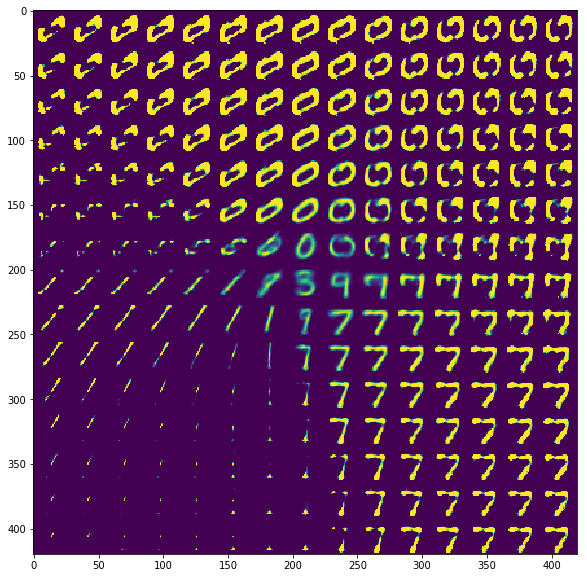

In [49]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
